# Machine Learning - HW2

Created and Edited by Ezz Maree & Saja Abed Elhadi.

***

# Table of Contents

### 1 [Libraries](#section1)

### 2 [Data Exploration and Visualization](#section2)

### 3 [Data Pre-Processing](#section3)

### 4 [Unit Sales Prediction](#section4)

### 5 [Rainy Day Prediction](#section5)

### 6 [Elevation Estimation](#section6)

### 7 [Clustering](#section7)

# 1 - Libraries <a class="anchor" id="section1"></a>

Importing libraries and functions that we'll be using

In [1]:
import warnings
warnings.filterwarnings('ignore')


# data and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pre-processing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper #Normalization


# prediction

# model building
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix

# random forest classifier
from sklearn.ensemble import RandomForestClassifier
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
# KNN
from sklearn.neighbors import KNeighborsClassifier
# adaboost
from sklearn.ensemble import AdaBoostRegressor
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
#SVR
from sklearn.svm import SVR
# random forest regressor
from sklearn.ensemble import RandomForestRegressor
#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor


from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from yellowbrick.regressor import residuals_plot

from sklearn import linear_model

from yellowbrick.regressor import PredictionError


# set seed for reproducible results
RSEED = 10

# 2 Data Exploration and Visualization <a class="anchor" id="section2"></a>

In this section, We Will explore and visualize the data and its variables to get a better understanding of what is required in the pre-processing section.

The weather dataset includes different features of the weather for 20 different weather stations in different locations in which they were recorded at certain dates

#### Variables - Weather Data:

1) **station_nbr**: unique identifier for each station

2) **date**: date of recording the weather data

**Temperature - Degrees Fahrenheit:**

3) **tmax**: Max Temperature

4) **tmin**: Min Temperature

5) **tavg**: Average Temperature

6) **depart**: DEPARTURE FROM NORMAL

7) **dewpoint**: AVERAGE DEW POINT

8) **wetbulb**: AVERAGE WET BULB

**Degree Days: Base 65 F**

9) **heat**: HEATING (SEASON BEGINS WITH JULY)

10) **cool**: COOLING (SEASON BEGINS WITH JANUARY)

11) **sunrise**: SUNRISE (Calculated, not observed)

12) **sunset**: SUNSET (Calculated, not observed)

**Significant Weather Types**

13) **codesum**: Weather Phenomena

**Precipitation:**

14) **snowfall**: SNOWFALL (INCHES AND TENTHS)(2400 LST)*, T = TRACE / M = MISSING DATA

15) **preciptotal**: WATER EQUIVALENT(INCHES & HUNDREDTHS(2400 LST), RAINFALL & MELTED SNOW, M = MISSING DATA / T = TRACE

**Pressure: INCHES OF HG**

16) **stnpressure**: AVERAGE STATION PRESSURE

17) **sealevel**: AVERAGE SEA LEVEL PRESSURE

**Wind: SPEED IN MILES PER HOUR, DIRECTION TO TENS OF DEGREES**

18) **resultspeed**: RESULTANT WIND SPEED

19) **resultdir**: RESULTANT DIRECTION - (WHOLE DEGREES)

20) **avgspeed**: AVERAGE SPEED

### * = Not all stations report snow totals
### M = Missing Data, or data that are not normally reported for the station.
### - = values not available for sunrise/sunset.

The second dataset - 'sales.csv' contains the sales of 111 items at 45 different stores/locations and the dates in which they were sold

#### Variables - Sales Data:

1) **date**: The date the items were sold

2) **store_nbr**: unique identifier for each store

3) **item_nbr**: unique identifer for each item

4) **units**: number of sold units for each item at a given date

### Sales Data

In [2]:
# import sales data
sales_df = pd.read_csv('sales.csv', parse_dates=['date'])

In [3]:
#show random set of rows
sales_df.sample(5, random_state=RSEED)

,date,store_nbr,item_nbr,units
4355096,2014-08-27,7,12,0
1062171,2012-08-04,2,13,0
3576478,2014-02-17,44,59,0
1702174,2012-12-10,7,101,0
1765952,2012-12-22,42,54,0


In [4]:
# data shape (rows, columns)
sales_df.shape

(4617600, 4)

In [5]:
sales_df.dtypes

date         datetime64[ns]
store_nbr             int64
item_nbr              int64
units                 int64
dtype: object

We notice that the columns store_nbr and item_nbr are defined as int while thier actual type must be Object since they're supposed to be categorical data types, so we'll be changing thier types later on the preprocessing phase

In [6]:
# missing values by variable
sales_df.isnull().sum()

date         0
store_nbr    0
item_nbr     0
units        0
dtype: int64

In [3]:
# since the dataframe is too big we need to filter the sales data by removing units with 0 value for the bonus sections
sales_df_units_filter = sales_df[sales_df.units != 0]
sales_df_units_filter.shape

(118696, 4)

In [157]:
# add new columns showing year and month separately and remove date column
sales_df_ym = sales_df.copy()
sales_df_ym['year'] = pd.DatetimeIndex(sales_df_ym['date']).year
sales_df_ym['month'] = pd.DatetimeIndex(sales_df_ym['date']).month
sales_df_ym = sales_df_ym.drop('date', 1)
sales_df_ym

,store_nbr,item_nbr,units,year,month
0,1,1,0,2012,1
1,1,2,0,2012,1
2,1,3,0,2012,1
3,1,4,0,2012,1
4,1,5,0,2012,1
...,...,...,...,...,...
4617595,45,107,0,2014,10
4617596,45,108,0,2014,10
4617597,45,109,0,2014,10
4617598,45,110,0,2014,10


In [158]:
# Group sales by Year and Month
sales_gb_my = sales_df_ym.groupby(['year', 'month'])['units'].sum()
sales_gb_my.index = pd.MultiIndex.from_tuples(sales_gb_my.index)
sales_gb_my

2012  1     183746
      2     167272
      3     166997
      4     162541
      5     160950
      6     173730
      7     173226
      8     177173
      9     165728
      10    163237
      11    158790
      12    173054
2013  1     167990
      2     146237
      3     151943
      4     109091
      5     108823
      6     107579
      7     118019
      8     121270
      9     107368
      10    118169
      11    126334
      12    132070
2014  1     132311
      2     106214
      3     117098
      4     108815
      5      87813
      6      93822
      7      85881
      8     109947
      9      85593
      10     88166
Name: units, dtype: int64

Text(0, 0.5, 'Units Sold')

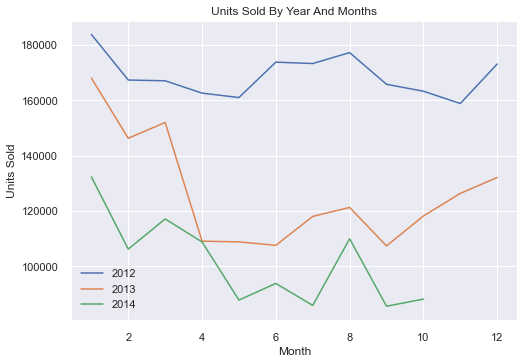

In [159]:
ax = sales_gb_my.unstack(0).plot()
ax.set_title("Units Sold By Year And Months")
ax.set_xlabel("Month")
ax.set_ylabel("Units Sold")

### The line chart above shows us the number of units sold in every month  from January 2012 to October 2014 without taking into account the weather data, now an interesting observation is that at the first month of each year the number of sales is at its peak and then starts going down and goes back up again at the end of the year, moreover we can see a clear decrease in sales over the years and we can clearly see an unusual spike in sales at August 2014.

In [160]:
sales_by_store = sales_df.groupby(['store_nbr'], as_index=False)['units'].sum()

In [161]:
#display the 10 highest sold units per store 
sales_by_store.nlargest(10, 'units')

,store_nbr,units
32,33,292616
16,17,271413
24,25,185025
1,2,173643
29,30,172604
15,16,165851
14,15,160554
37,38,148750
12,13,143602
33,34,141546


stores 33 and 17 have sold the most units and they're actually distinct from other stores in terms of unit sales 

In [162]:
#display the 10 lowest sold units per store 
sales_by_store.nsmallest(10, 'units')

,store_nbr,units
38,39,14931
44,45,20252
13,14,28590
18,19,29037
17,18,29158
4,5,36454
0,1,37629
34,35,38275
7,8,45427
11,12,50448


store number 39 has the lowest unit sales

In [163]:
sales_by_item = sales_df.groupby(['item_nbr'], as_index=False)['units'].sum()

In [164]:
#display the 10 highest sold units per item 
sales_by_item.nlargest(10, 'units')

,item_nbr,units
44,45,1005111
8,9,916615
4,5,846662
43,44,577193
15,16,226772
67,68,172243
24,25,148253
36,37,125156
35,36,83865
47,48,76092


We notice that the items 45, 9 and 5 have sold the most units and they seem close to each other in terms of sales than than the rest of the items

In [165]:
#display the 10 lowest sold units per item 
sales_by_item.nsmallest(10, 'units')

,item_nbr,units
101,102,31
33,34,110
105,106,139
88,89,157
21,22,162
87,88,223
83,84,235
102,103,241
84,85,248
39,40,254


item_nbr 102 has the lowest unit sales by a margin

### Keys Data

In [4]:
# import keys data
keys_df = pd.read_csv('key.csv')

In [9]:
# data shape (rows, columns)
keys_df.shape

(45, 2)

In [10]:
len(keys_df['station_nbr'].unique())

20

20 out of the 45 weather stations are present in the keys data

In [169]:
# display descriptive statistics for numeric variables
keys_df.sample(5, random_state=RSEED)

,store_nbr,station_nbr
30,31,17
10,11,10
20,21,3
33,34,17
34,35,5


In [170]:
keys_df.dtypes

store_nbr      int64
station_nbr    int64
dtype: object

In [171]:
# missing values by variable
keys_df.isnull().sum()

store_nbr      0
station_nbr    0
dtype: int64

### Weather Data

In [5]:
# import weather data while parsing the dates to date type and replacing missing values with null for the time being
weather_df = pd.read_csv("weather.csv", na_values=["M", "-", "*"], parse_dates=['date'])

In [12]:
# look at 5 random observations 
weather_df.sample(5, random_state=RSEED)

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
7069,2,2012-12-27,33.0,27.0,30.0,4.0,30.0,31.0,35.0,0.0,715.0,1622.0,RA FZRA SN BR UP,3.0,0.91,28.40,29.49,13.9,1.0,18.1
19202,6,2014-08-27,97.0,71.0,84.0,1.0,66.0,72.0,0.0,19.0,605.0,1900.0,,0.0,0.00,29.44,29.94,3.8,10.0,4.8
9124,17,2013-04-08,76.0,63.0,70.0,NaN,58.0,62.0,0.0,5.0,NaN,NaN,BR,0.0,0.00,29.01,29.70,10.8,16.0,10.9
6520,13,2012-11-29,62.0,27.0,45.0,NaN,16.0,34.0,20.0,0.0,NaN,NaN,,NaN,0.00,24.24,30.01,2.3,19.0,5.8
115,2,2012-01-07,56.0,37.0,47.0,23.0,29.0,38.0,18.0,0.0,716.0,1631.0,,0.0,0.00,28.63,29.75,8.9,26.0,9.6


In [174]:
weather_df.shape

(20517, 20)

In [175]:
weather_df.dtypes

station_nbr             int64
date           datetime64[ns]
tmax                  float64
tmin                  float64
tavg                  float64
depart                float64
dewpoint              float64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
snowfall               object
preciptotal            object
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
dtype: object

In [176]:
# missing values by variable
weather_df.isnull().sum()

station_nbr        0
date               0
tmax             906
tmin             908
tavg            1469
depart         11511
dewpoint         666
wetbulb         1252
heat            1469
cool            1469
sunrise         9656
sunset          9656
codesum            0
snowfall        7224
preciptotal      860
stnpressure      929
sealevel        1724
resultspeed      589
resultdir        589
avgspeed         875
dtype: int64

### Merged Weather Data with Sales Data

In [6]:
weather_keys = weather_df.copy().merge(right = keys_df.copy(), left_on = ['station_nbr'], right_on = ['station_nbr'])
weather_keys

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr
0,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,RA FZFG BR,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1
1,1,2012-01-02,50.0,31.0,41.0,NaN,26.0,35.0,24.0,0.0,...,NaN,,NaN,0.01,29.44,29.62,9.8,24.0,10.3,1
2,1,2012-01-03,32.0,11.0,22.0,NaN,4.0,18.0,43.0,0.0,...,NaN,,NaN,0.00,29.67,29.87,10.8,31.0,11.6,1
3,1,2012-01-04,28.0,9.0,19.0,NaN,-1.0,14.0,46.0,0.0,...,NaN,,NaN,0.00,29.86,30.03,6.3,27.0,8.3,1
4,1,2012-01-05,38.0,25.0,32.0,NaN,13.0,25.0,33.0,0.0,...,NaN,,NaN,0.00,29.67,29.84,6.9,25.0,7.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46387,5,2014-10-27,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,...,1645.0,,NaN,NaN,NaN,29.91,13.4,28.0,NaN,35
46388,5,2014-10-28,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,...,1644.0,,NaN,NaN,NaN,30.03,7.0,19.0,NaN,35
46389,5,2014-10-29,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,...,1643.0,,NaN,NaN,NaN,29.87,8.2,23.0,NaN,35
46390,5,2014-10-30,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,...,1641.0,,NaN,NaN,NaN,29.95,8.3,30.0,NaN,35


In [178]:
weather_sales = weather_keys.copy().merge(right = sales_df.copy(), left_on = ['store_nbr', 'date'], right_on = ['store_nbr', 'date'])
weather_sales

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr,item_nbr,units
0,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1,1,0
1,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1,2,0
2,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1,3,0
3,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1,4,0
4,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617595,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,NaN,30.01,10.8,5.0,NaN,35,107,0
4617596,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,NaN,30.01,10.8,5.0,NaN,35,108,0
4617597,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,NaN,30.01,10.8,5.0,NaN,35,109,0
4617598,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,NaN,30.01,10.8,5.0,NaN,35,110,0


Let's take a look at the correlation between the temprature related features

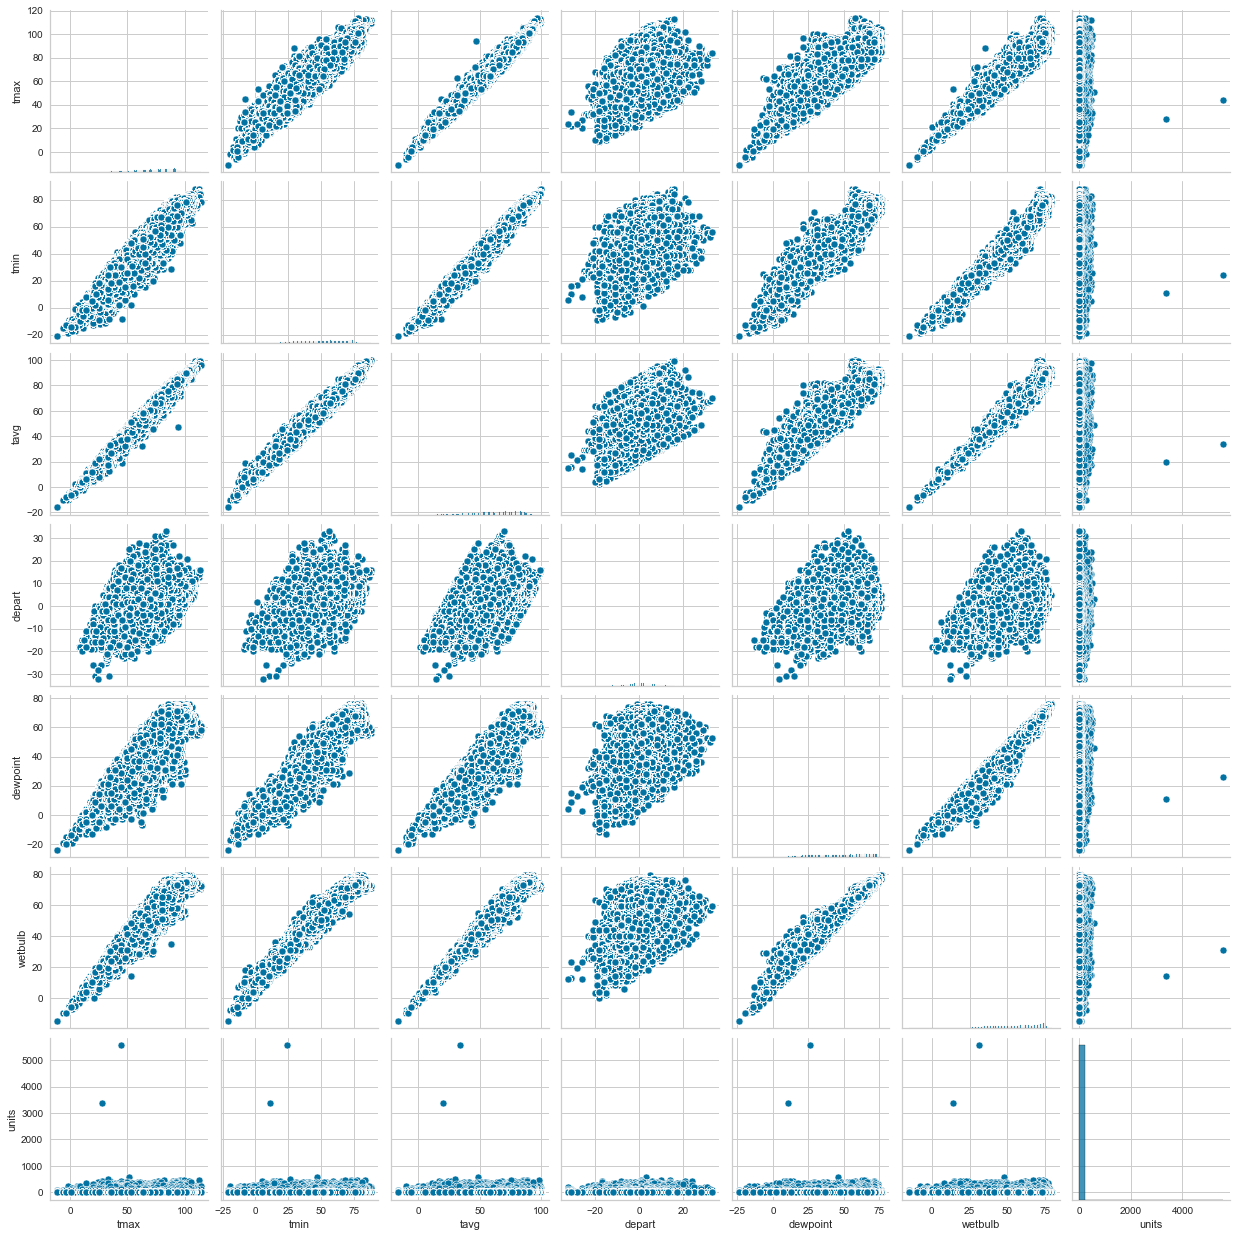

In [29]:
#show correlation between these numeric features - Temp Features
cols = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'units']
sns.pairplot(weather_sales[cols])
plt.show()

The features: tmin, tmax, wetbulb have a strong correlation with tavg and no correlation with the number of units.
We also notice a strong correlation between dewpoint and wetbulb.
depart has no correlation whatsoever with any of the temprature features.

Show the Correlation between Degree Days: Base 65 F Features
Note: we add preciptotal and snowfall here since we haven't changed them yet to category types

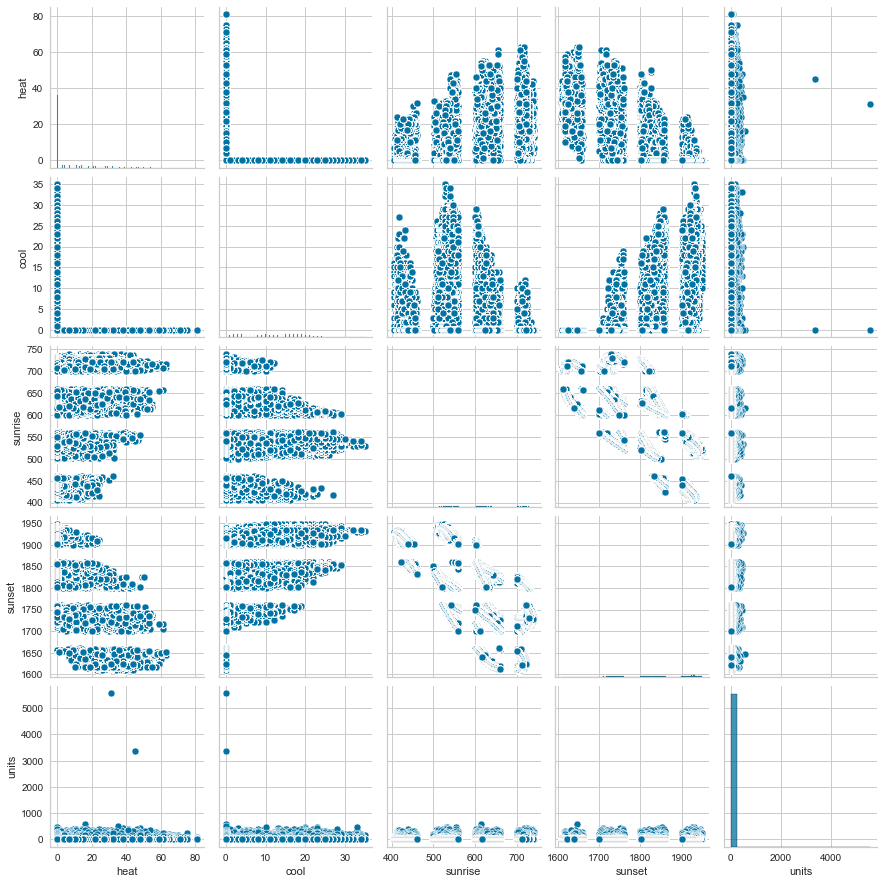

In [30]:
#show correlation between these numeric features
cols = ['heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal', 'units']
sns.pairplot(weather_sales[cols])
plt.show()

No Correlation between any of the features

Let's take a look at the correlation between the pressure and wind related features

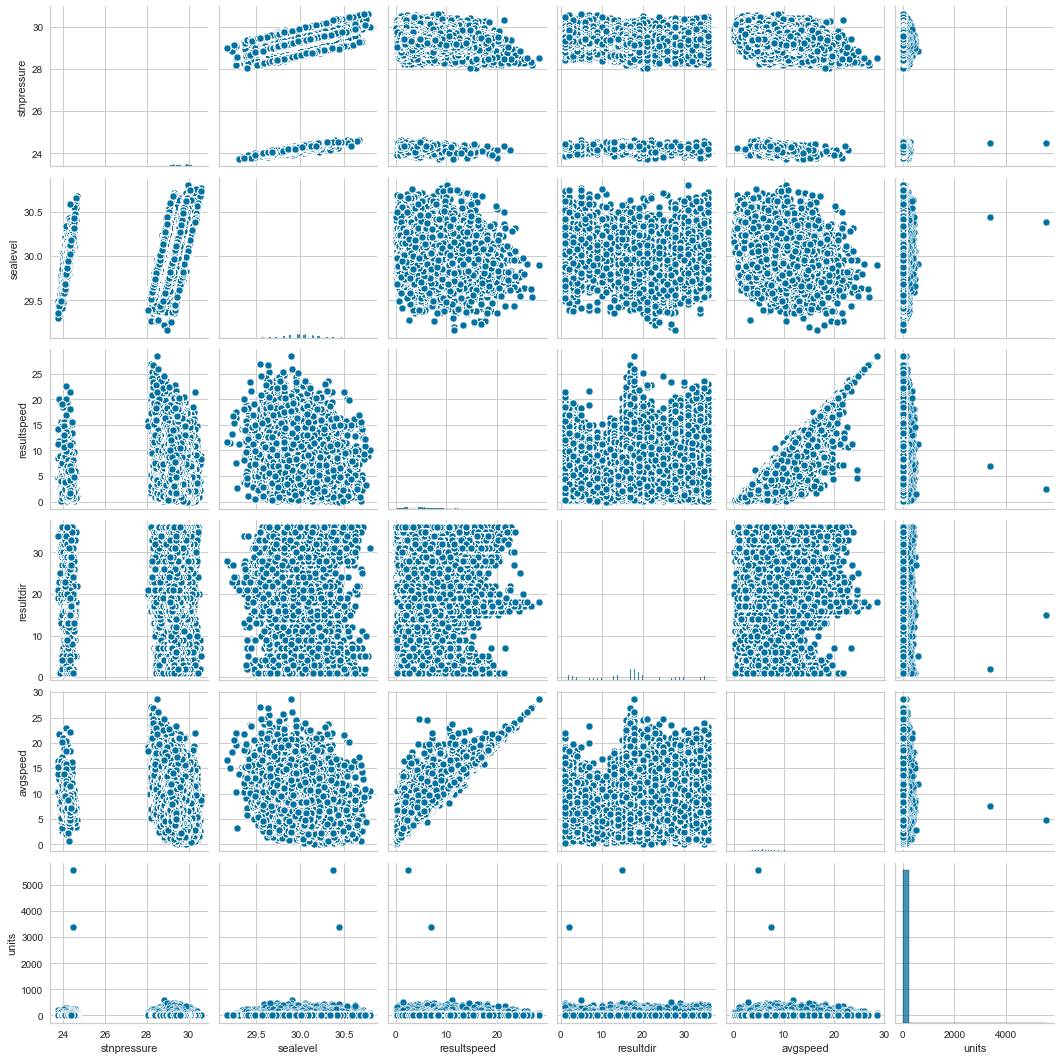

In [31]:
#show correlation between these numeric features - pressure and wind
cols = ['stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'units']
sns.pairplot(weather_sales[cols])
plt.show()

We notice a weak correlation between resultspeed and avgspeed, and no other correlations between the other features

### Dataframe For Rainy Day Prediction

In [36]:
rainy_day = weather_sales.copy()
rainy_day = rainy_day[['date', 'store_nbr', 'item_nbr', 'units', 'preciptotal']]
rainy_day = rainy_day[rainy_day['store_nbr'] == 11]
rainy_day

,date,store_nbr,item_nbr,units,preciptotal
1430901,2012-01-01,11,1,0,0.00
1430902,2012-01-01,11,2,0,0.00
1430903,2012-01-01,11,3,0,0.00
1430904,2012-01-01,11,4,0,0.00
1430905,2012-01-01,11,5,0,0.00
...,...,...,...,...,...
1729708,2014-10-31,11,107,0,0.00
1729709,2014-10-31,11,108,0,0.00
1729710,2014-10-31,11,109,0,0.00
1729711,2014-10-31,11,110,14,0.00


### Weather & Sales Data

In [179]:
weather_sales.isnull().sum()

station_nbr          0
date                 0
tmax            111444
tmin            111333
tavg            187701
depart         3070038
dewpoint         91020
wetbulb         167499
heat            187701
cool            187701
sunrise        2680539
sunset         2680539
codesum              0
snowfall       1656786
preciptotal      98901
stnpressure     109890
sealevel        214674
resultspeed      75480
resultdir        75480
avgspeed        101454
store_nbr            0
item_nbr             0
units                0
dtype: int64

we have so many null values, and we need to replace them in the preprocessing phase

Weather Sales by Codesum

In [34]:
weather_sales_byCodesum = weather_sales.groupby(['codesum'], as_index=False)['units'].sum()
weather_sales_byCodesum

,codesum,units
0,,2607270
1,BCFG,4158
2,BCFG BR,9531
3,BCFG BR HZ,1771
4,BCFG HZ,210
...,...,...
404,TSSN UP VCTS,12
405,UP,3483
406,UP HZ,460
407,VCFG,241


In [35]:
highest_ws = weather_sales_byCodesum.nlargest(5, 'units')

In [36]:
highest_ws

,codesum,units
0,,2607270
120,RA,284204
7,BR,279782
124,RA BR,242850
10,BR HZ,87921


a codesum of value ' ' indicates that none of the significant weather types occured and we can call it normal instead of a blank value 

In [37]:
# replace field that's entirely space (or empty) with NaN
freq = highest_ws.replace(r'^\s*$', 'Normal', regex=True)

In [38]:
freq["codesum"] = freq["codesum"].str.replace("RA", "RAIN")
freq["codesum"] = freq["codesum"].str.replace("BR", "MIST")
freq["codesum"] = freq["codesum"].str.replace("HZ", "HAZE")
freq

,codesum,units
0,Normal,2607270
120,RAIN,284204
7,MIST,279782
124,RAIN MIST,242850
10,MIST HAZE,87921


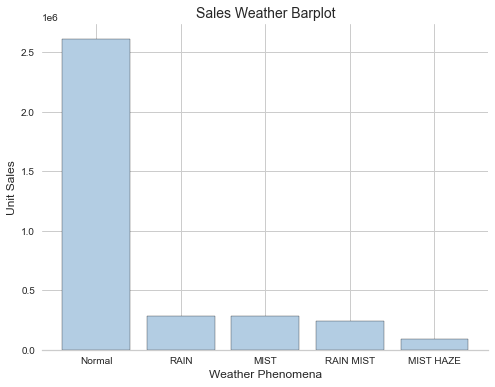

In [39]:
plt.figure(figsize=(8, 6))
plt.bar(freq['codesum'], freq['units'], color = '#b3cde3', edgecolor='black')
# plt.xticks([1, 2, 3, 4])
plt.title('Sales Weather Barplot', fontsize=14)
plt.xlabel('Weather Phenomena', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
sns.despine(top=True, right=True, bottom=False, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.show()

observing the barplot above we clearly see that sales when the weather is normal and none of the other significant weather types occurs the sales are the highest by a big margin then its followed by other weather phenomenas like rain and mist have almost the same sales, Rain and mist a little lower followed by mist and haze which is the lowest out of the five.

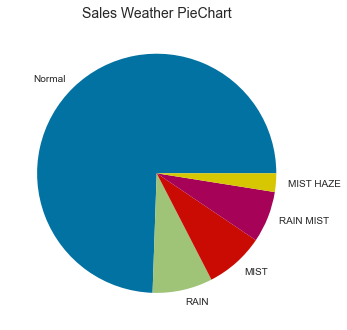

In [40]:
plt.pie(freq['units'], labels = freq['codesum'])
plt.title('Sales Weather PieChart', fontsize=14)
plt.show() 

### DataFrame for Unit Sales Prediction

In [180]:
weather_unit_sales_predData = weather_sales.copy()
#filter the dataframe by items: 5, 6, 9, 16 and 45
weather_unit_sales_predData = weather_unit_sales_predData[weather_unit_sales_predData['item_nbr'].isin([5, 6, 9, 16, 45])]
#group by store_nbr and date and sum the units
weather_unit_sales_predData['key_sum'] = weather_unit_sales_predData.groupby(['store_nbr', 'date'], as_index=False)['units'].transform('sum')
weather_unit_sales_predData

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr,item_nbr,units,key_sum
4,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0.05,29.78,29.92,3.6,20.0,4.6,1,5,0,29
5,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0.05,29.78,29.92,3.6,20.0,4.6,1,6,0,29
8,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0.05,29.78,29.92,3.6,20.0,4.6,1,9,29,29
15,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0.05,29.78,29.92,3.6,20.0,4.6,1,16,0,29
44,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0.05,29.78,29.92,3.6,20.0,4.6,1,45,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617493,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,30.01,10.8,5.0,NaN,35,5,0,18
4617494,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,30.01,10.8,5.0,NaN,35,6,0,18
4617497,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,30.01,10.8,5.0,NaN,35,9,0,18
4617504,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,30.01,10.8,5.0,NaN,35,16,18,18


In [181]:
weather_unit_sales_predData['units'].equals(weather_unit_sales_predData['key_sum'])

False

In [182]:
# change station_nbr, item_nbr, store_nbr and codesum data type to category
weather_unit_sales_predData['station_nbr'] = weather_unit_sales_predData['station_nbr'].astype('object')
weather_unit_sales_predData['item_nbr'] = weather_unit_sales_predData['item_nbr'].astype('object')
weather_unit_sales_predData['store_nbr'] = weather_unit_sales_predData['store_nbr'].astype('object')
# weather_sales['codesum'] = weather_sales['codesum'].astype('category')

We're gonna add a holiday column to check if sales were also affected by holidays or not

In [183]:
dr = pd.date_range(start='2012-01-01', end='2014-10-31')
df = pd.DataFrame()

cols = [ val for val in weather_sales.columns if val != 'units' and val != 'station_nbr' and val != 'store_nbr' and val != 'item_nbr']
temp = pd.concat([weather_sales.groupby(['date'])[cols].mean(), weather_sales.drop(['store_nbr'], 1).groupby(['date'])['units'].sum()], axis=1).reset_index()


cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

temp['Holiday'] = temp['date'].isin(holidays)
print(temp)

           date       tmax       tmin       tavg   depart   dewpoint  \
0    2012-01-01  54.977273  35.363636  45.093023   6.9375  30.886364   
1    2012-01-02  49.977273  28.522727  39.255814   0.2500  20.227273   
2    2012-01-03  50.250000  23.750000  37.023256  -2.2500  16.159091   
3    2012-01-04  54.340909  27.181818  40.674419   2.6875  21.227273   
4    2012-01-05  62.613636  30.386364  46.465116   8.2500  28.681818   
...         ...        ...        ...        ...      ...        ...   
1029 2014-10-27  77.204545  55.590909  66.613636  11.3750  51.111111   
1030 2014-10-28  71.818182  48.272727  60.340909   4.8750  46.466667   
1031 2014-10-29  73.545455  46.340909  60.204545   3.1875  45.111111   
1032 2014-10-30  72.477273  47.386364  60.159091   4.5625  44.488889   
1033 2014-10-31  61.954545  42.000000  52.250000  -5.0625  36.613636   

        wetbulb       heat      cool     sunrise       sunset  stnpressure  \
0     39.136364  19.906977  0.000000  728.789474  1715.63

We're also gonna add Year, Month, Day, DayOfWeek and isWeekend columns to the dataframe to check if they also affect the number of sales

In [45]:
temp['Year'] = pd.DatetimeIndex(temp['date']).year
temp['Month'] = pd.DatetimeIndex(temp['date']).month
temp['Day'] = pd.DatetimeIndex(temp['date']).day
#df = df.drop('date', 1)
dates = pd.to_datetime({"year": temp.Year, "month": temp.Month, "day": temp.Day})
temp["DayofWeek"] = dates.dt.dayofweek
temp["IsWeekend"] = dates.dt.dayofweek > 4
#temp = df.drop(['Year', 'Month', 'Day', ])
print(temp)

           date       tmax       tmin       tavg   depart   dewpoint  \
0    2012-01-01  54.977273  35.363636  45.093023   6.9375  30.886364   
1    2012-01-02  49.977273  28.522727  39.255814   0.2500  20.227273   
2    2012-01-03  50.250000  23.750000  37.023256  -2.2500  16.159091   
3    2012-01-04  54.340909  27.181818  40.674419   2.6875  21.227273   
4    2012-01-05  62.613636  30.386364  46.465116   8.2500  28.681818   
...         ...        ...        ...        ...      ...        ...   
1029 2014-10-27  77.204545  55.590909  66.613636  11.3750  51.111111   
1030 2014-10-28  71.818182  48.272727  60.340909   4.8750  46.466667   
1031 2014-10-29  73.545455  46.340909  60.204545   3.1875  45.111111   
1032 2014-10-30  72.477273  47.386364  60.159091   4.5625  44.488889   
1033 2014-10-31  61.954545  42.000000  52.250000  -5.0625  36.613636   

        wetbulb       heat      cool     sunrise  ...  resultspeed  resultdir  \
0     39.136364  19.906977  0.000000  728.789474  ... 

Text(0.5, 1.0, 'Unit Sales By Day of Week')

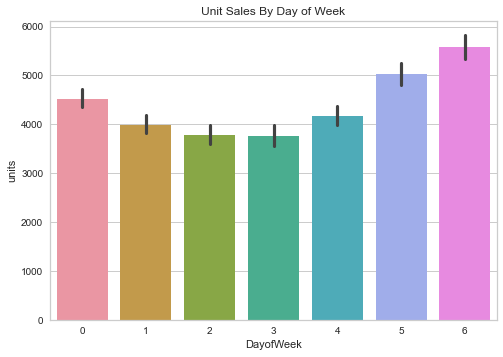

In [47]:
sns.barplot(x="DayofWeek", y="units", data=temp).set_title('Unit Sales By Day of Week')

We notice that the highest sales are on the weekend days like Friday and Saturday

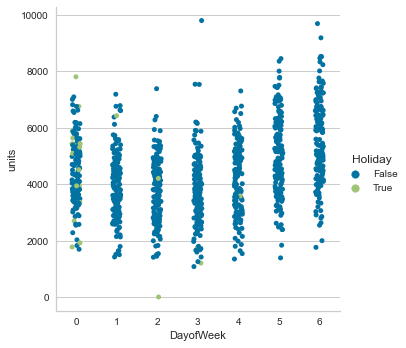

In [50]:
sns.catplot(x="DayofWeek", y="units", hue='Holiday', data=temp)

since most of the holidays happend to be on the first day of the week we're goonna try and analyse the sales on that day, most of the units sales are similar whether there was a holiday or not but we can also notice an unusual unit sales that is distinct from the rest and on this day happens to be a Holiday, and the highest sales as we noticed in the previous barplot are on the weekends

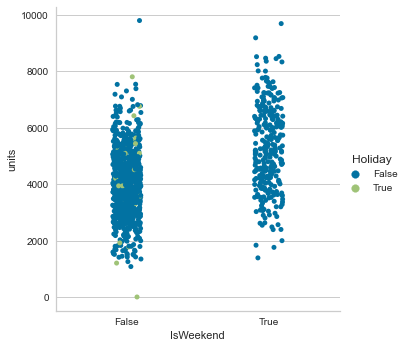

In [313]:
sns.catplot(x="IsWeekend", y="units", hue='Holiday', data=temp)

this graph confirms the fact that the sales are at its peak on the weekends

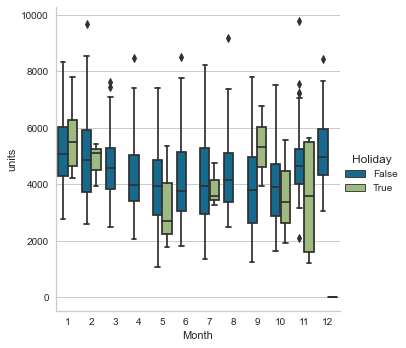

In [315]:
sns.catplot(x="Month", y="units", hue='Holiday', kind="box", data=temp)

the boxplot above shows the unit sales per month and Holiday, but surprisingly enough most of the outliers appear to happen on days that are not Holidays

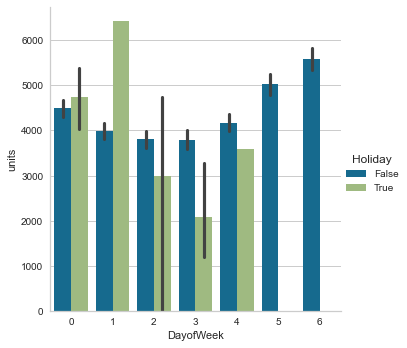

In [316]:
sns.catplot(x="DayofWeek", y="units", hue="Holiday", kind="bar", data=temp)

### Merged DataFrame for bonus sections

In [67]:
weather_sales_filtered = weather_keys.copy().merge(right = sales_df_units_filter.copy(), left_on = ['store_nbr', 'date'], right_on = ['store_nbr', 'date'])
weather_sales_filtered

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,store_nbr,item_nbr,units
0,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1,9,29
1,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1,28,2
2,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,NaN,0.05,29.78,29.92,3.6,20.0,4.6,1,51,1
3,1,2012-01-02,50.0,31.0,41.0,NaN,26.0,35.0,24.0,0.0,...,NaN,0.01,29.44,29.62,9.8,24.0,10.3,1,9,60
4,1,2012-01-02,50.0,31.0,41.0,NaN,26.0,35.0,24.0,0.0,...,NaN,0.01,29.44,29.62,9.8,24.0,10.3,1,28,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118691,5,2014-10-29,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,...,NaN,NaN,NaN,29.87,8.2,23.0,NaN,35,66,14
118692,5,2014-10-30,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,...,NaN,NaN,NaN,29.95,8.3,30.0,NaN,35,16,16
118693,5,2014-10-30,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,...,NaN,NaN,NaN,29.95,8.3,30.0,NaN,35,66,6
118694,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,NaN,NaN,NaN,30.01,10.8,5.0,NaN,35,16,18


# 3 Data Pre-Processing <a class="anchor" id="section3"></a>

In this section, We're gonna apply several pre-processing methods to the data in order to prepare it for the models that we wish to apply in the next section.

### Rainy Day Prediction Data

In [317]:
rainy_day.isnull().sum()

date           0
store_nbr      0
item_nbr       0
units          0
preciptotal    0
dtype: int64

In [318]:
rainy_day.dtypes

date           datetime64[ns]
store_nbr               int64
item_nbr                int64
units                   int64
preciptotal            object
dtype: object

In [319]:
set(rainy_day['preciptotal'])

{'  T',
 '0.00',
 '0.01',
 '0.02',
 '0.03',
 '0.04',
 '0.05',
 '0.06',
 '0.07',
 '0.08',
 '0.09',
 '0.10',
 '0.11',
 '0.12',
 '0.13',
 '0.14',
 '0.15',
 '0.16',
 '0.17',
 '0.18',
 '0.19',
 '0.21',
 '0.22',
 '0.23',
 '0.24',
 '0.26',
 '0.27',
 '0.28',
 '0.29',
 '0.30',
 '0.31',
 '0.32',
 '0.33',
 '0.34',
 '0.35',
 '0.37',
 '0.38',
 '0.39',
 '0.40',
 '0.41',
 '0.42',
 '0.43',
 '0.45',
 '0.46',
 '0.47',
 '0.48',
 '0.49',
 '0.51',
 '0.52',
 '0.53',
 '0.56',
 '0.59',
 '0.60',
 '0.61',
 '0.62',
 '0.63',
 '0.67',
 '0.69',
 '0.71',
 '0.72',
 '0.73',
 '0.75',
 '0.76',
 '0.77',
 '0.79',
 '0.82',
 '0.84',
 '0.85',
 '0.88',
 '0.89',
 '0.92',
 '0.93',
 '0.98',
 '1.01',
 '1.07',
 '1.08',
 '1.09',
 '1.18',
 '1.30',
 '1.45',
 '1.65',
 '1.71',
 '1.80',
 '1.96',
 '2.15',
 '2.81',
 '2.84',
 '3.19',
 '3.47',
 '3.91',
 '4.65',
 '4.84'}

In [320]:
def change_preciptotal(x):
    if x == "  T":
        return 0.001    
    else:
        return float(x)
    
rainy_day["preciptotal"] = rainy_day["preciptotal"].map(change_preciptotal)

T above will mean Trace that with respect to internet for snow will mean that is was some rain, but it was less than 0.1 inch. I will assume that T is equal to 0.001, just to distinguish it from 0.

In [321]:
def change_preciptotal_Rain(x):
    if x == 0:
        return False   
    else:
        return True
    
rainy_day["preciptotal"] = rainy_day["preciptotal"].map(change_preciptotal_Rain)

In [322]:
set(rainy_day["preciptotal"])

{False, True}

In [323]:
rainy_day[rainy_day["preciptotal"] == True]

,date,store_nbr,item_nbr,units,preciptotal
1432899,2012-01-07,11,1,0,True
1432900,2012-01-07,11,2,0,True
1432901,2012-01-07,11,3,0,True
1432902,2012-01-07,11,4,0,True
1432903,2012-01-07,11,5,0,True
...,...,...,...,...,...
1729375,2014-10-30,11,107,0,True
1729376,2014-10-30,11,108,0,True
1729377,2014-10-30,11,109,0,True
1729378,2014-10-30,11,110,13,True


In [324]:
rainy_day.rename(columns = {'preciptotal':'Rainy_Day'}, inplace = True)
rainy_day

,date,store_nbr,item_nbr,units,Rainy_Day
1430901,2012-01-01,11,1,0,False
1430902,2012-01-01,11,2,0,False
1430903,2012-01-01,11,3,0,False
1430904,2012-01-01,11,4,0,False
1430905,2012-01-01,11,5,0,False
...,...,...,...,...,...
1729708,2014-10-31,11,107,0,False
1729709,2014-10-31,11,108,0,False
1729710,2014-10-31,11,109,0,False
1729711,2014-10-31,11,110,14,False


In [325]:
rainy_day['Year'] = pd.DatetimeIndex(rainy_day['date']).year
rainy_day['Month'] = pd.DatetimeIndex(rainy_day['date']).month
rainy_day['Day'] = pd.DatetimeIndex(rainy_day['date']).day
rainy_day

,date,store_nbr,item_nbr,units,Rainy_Day,Year,Month,Day
1430901,2012-01-01,11,1,0,False,2012,1,1
1430902,2012-01-01,11,2,0,False,2012,1,1
1430903,2012-01-01,11,3,0,False,2012,1,1
1430904,2012-01-01,11,4,0,False,2012,1,1
1430905,2012-01-01,11,5,0,False,2012,1,1
...,...,...,...,...,...,...,...,...
1729708,2014-10-31,11,107,0,False,2014,10,31
1729709,2014-10-31,11,108,0,False,2014,10,31
1729710,2014-10-31,11,109,0,False,2014,10,31
1729711,2014-10-31,11,110,14,False,2014,10,31


In [326]:
rainy_day.iloc[:, 1:] = rainy_day.iloc[:, 1:].astype('object')
rainy_day['units'] = rainy_day['units'].astype('float')

In [327]:
rainy_day.dtypes

date         datetime64[ns]
store_nbr            object
item_nbr             object
units               float64
Rainy_Day            object
Year                 object
Month                object
Day                  object
dtype: object

### One Hot Encoding - Rainy Data

In [328]:
# change Stage data type to category
rainy_day['Rainy_Day'] = rainy_day['Rainy_Day'].astype('category')

In [329]:
# create different datasets for numeric and categorical variables
numeric_features= rainy_day.select_dtypes(include='number')
categorical_features = rainy_day.select_dtypes(include='object')

In [330]:
# get categorical variables after dropping observations
categorical_features = rainy_day[categorical_features.columns]

In [331]:
# one-hot encoding
encoded = pd.get_dummies(categorical_features, drop_first=True)

In [332]:
# drop categorical variables
rainy_day.drop(categorical_features.columns, axis=1, inplace=True)

In [333]:
# add new encoded variables to the dataframe
rainy_day = pd.concat([rainy_day, encoded], axis=1)

In [334]:
rainy_day.head()

,date,units,Rainy_Day,item_nbr_2,item_nbr_3,item_nbr_4,item_nbr_5,item_nbr_6,item_nbr_7,item_nbr_8,...,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
1430901,2012-01-01,0.0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1430902,2012-01-01,0.0,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1430903,2012-01-01,0.0,False,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1430904,2012-01-01,0.0,False,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1430905,2012-01-01,0.0,False,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Sales Units Prediction Data

Replace date column with day, month, year columns and add Dayofweek, holiday and weekend columns

In [184]:
weather_unit_sales_predData.shape

(208000, 24)

In [185]:
# drop observations that don't have at least 12 features
weather_unit_sales_predData.dropna(thresh=13, axis=0, inplace=True)

In [186]:
weather_unit_sales_predData.shape

(205170, 24)

In [187]:
#preparing data for section C
weather_unit_sales_predData['Year'] = pd.DatetimeIndex(weather_unit_sales_predData['date']).year
weather_unit_sales_predData['Month'] = pd.DatetimeIndex(weather_unit_sales_predData['date']).month
weather_unit_sales_predData['Day'] = pd.DatetimeIndex(weather_unit_sales_predData['date']).day
dates = pd.to_datetime({"year": weather_unit_sales_predData.Year, "month": weather_unit_sales_predData.Month, "day": weather_unit_sales_predData.Day})
weather_unit_sales_predData["DayofWeek"] = dates.dt.dayofweek
weather_unit_sales_predData["IsWeekend"] = dates.dt.dayofweek > 4
weather_unit_sales_predData['Holiday'] = weather_unit_sales_predData['date'].isin(holidays)

In [188]:
# look at 5 random observations - train data
weather_unit_sales_predData.sample(5, random_state=RSEED)

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,store_nbr,item_nbr,units,key_sum,Year,Month,Day,DayofWeek,IsWeekend,Holiday
4006478,17,2013-10-24,59.0,42.0,51.0,NaN,37.0,44.0,14.0,0.0,...,9,45,50,70,2013,10,24,3,False,False
2354103,13,2012-02-19,48.0,27.0,38.0,NaN,17.0,28.0,27.0,0.0,...,40,16,0,238,2012,2,19,6,True,False
1738082,11,2012-02-06,66.0,56.0,61.0,7.0,57.0,58.0,4.0,0.0,...,43,45,0,72,2012,2,6,0,False,False
1562999,10,2013-02-01,64.0,43.0,54.0,NaN,28.0,42.0,11.0,0.0,...,27,9,38,38,2013,2,1,4,False,False
3442791,16,2012-11-08,40.0,32.0,36.0,NaN,33.0,36.0,29.0,0.0,...,14,16,0,34,2012,11,8,3,False,False


In [189]:
set(weather_unit_sales_predData["snowfall"])

{'  T',
 '0.0',
 '0.1',
 '0.2',
 '0.3',
 '0.4',
 '0.5',
 '0.6',
 '0.7',
 '0.8',
 '0.9',
 '1.0',
 '1.1',
 '1.2',
 '1.3',
 '1.4',
 '1.5',
 '1.6',
 '1.7',
 '1.8',
 '1.9',
 '11.0',
 '13.1',
 '13.5',
 '14.9',
 '15.2',
 '16.2',
 '2.0',
 '2.1',
 '2.2',
 '2.3',
 '2.4',
 '2.6',
 '2.8',
 '3.0',
 '3.1',
 '3.2',
 '3.4',
 '3.5',
 '3.6',
 '3.7',
 '4.0',
 '4.2',
 '4.3',
 '4.4',
 '4.6',
 '4.7',
 '5.0',
 '5.2',
 '5.4',
 '5.5',
 '6.1',
 '7.1',
 '7.2',
 '7.7',
 '7.8',
 '9.3',
 nan}

T above means Trace which implies that there was some snow, for the time being wer're going to assume that T is equal to 0.01.
in addition to that we're going to change the type of the snowfall column to a category, a value higher than 0 will indicate there was snowfall and will be mapped to True, otherwise the value will be mapped to False which indicates that there was no snowfall.

In [190]:
set(weather_unit_sales_predData["preciptotal"])

{'  T',
 '0.00',
 '0.01',
 '0.02',
 '0.03',
 '0.04',
 '0.05',
 '0.06',
 '0.07',
 '0.08',
 '0.09',
 '0.10',
 '0.11',
 '0.12',
 '0.13',
 '0.14',
 '0.15',
 '0.16',
 '0.17',
 '0.18',
 '0.19',
 '0.20',
 '0.21',
 '0.22',
 '0.23',
 '0.24',
 '0.25',
 '0.26',
 '0.27',
 '0.28',
 '0.29',
 '0.30',
 '0.31',
 '0.32',
 '0.33',
 '0.34',
 '0.35',
 '0.36',
 '0.37',
 '0.38',
 '0.39',
 '0.40',
 '0.41',
 '0.42',
 '0.43',
 '0.44',
 '0.45',
 '0.46',
 '0.47',
 '0.48',
 '0.49',
 '0.50',
 '0.51',
 '0.52',
 '0.53',
 '0.54',
 '0.55',
 '0.56',
 '0.57',
 '0.58',
 '0.59',
 '0.60',
 '0.61',
 '0.62',
 '0.63',
 '0.64',
 '0.65',
 '0.66',
 '0.67',
 '0.68',
 '0.69',
 '0.70',
 '0.71',
 '0.72',
 '0.73',
 '0.74',
 '0.75',
 '0.76',
 '0.77',
 '0.78',
 '0.79',
 '0.80',
 '0.81',
 '0.82',
 '0.83',
 '0.84',
 '0.85',
 '0.86',
 '0.87',
 '0.88',
 '0.89',
 '0.90',
 '0.91',
 '0.92',
 '0.93',
 '0.94',
 '0.95',
 '0.96',
 '0.97',
 '0.98',
 '0.99',
 '1.00',
 '1.01',
 '1.03',
 '1.04',
 '1.05',
 '1.06',
 '1.07',
 '1.08',
 '1.09',
 '1.10',
 '

Similar to snowfall column T above means Trace which implies that there was some rain, for the time being wer're going to assume that T is equal to 0.01.
in addition to that we're going to change the type of the preciptotal column to a category, a value higher than 0 will indicate there was rain and will be mapped to True, otherwise the value will be mapped to False which indicates that there was no rain.

In [191]:
def change_snowfall(x):
    if x == "  T":
        return 0.01    
    else:
        return float(x)
    
weather_unit_sales_predData["snowfall"] = weather_unit_sales_predData["snowfall"].map(change_snowfall)

In [192]:
def change_snowfall_category(x):
    if np.isnan(x):
        return float(x)   
    else:
        if x > 0:
            return True
        else:
            return False
    
weather_unit_sales_predData["snowfall"] = weather_unit_sales_predData["snowfall"].map(change_snowfall_category)

In [193]:
weather_unit_sales_predData["snowfall"].unique()

array([nan, False, True], dtype=object)

In [194]:
def change_preciptotal(x):
    if x == "  T":
        return 0.01    
    else:
        return float(x)
    
weather_unit_sales_predData["preciptotal"] = weather_unit_sales_predData["preciptotal"].map(change_preciptotal)

In [195]:
def change_preciptotal_category(x):
    if np.isnan(x):
        return float(x)   
    else:
        if x > 0:
            return True
        else:
            return False
        
weather_unit_sales_predData["preciptotal"] = weather_unit_sales_predData["preciptotal"].map(change_preciptotal_category)

In [196]:
weather_unit_sales_predData["preciptotal"].unique()

array([True, False, nan], dtype=object)

In [197]:
# replace codesum field that's entirely space (or empty) with Normal
weather_unit_sales_predData["codesum"] = weather_unit_sales_predData["codesum"].replace(r'^\s*$', 'Normal', regex=True)

In [198]:
codesum_columns = set(' '.join(set(weather_unit_sales_predData["codesum"])).strip().split())

In [199]:
codesum_columns

{'BCFG',
 'BLDU',
 'BLSN',
 'BR',
 'DU',
 'DZ',
 'FG',
 'FG+',
 'FU',
 'FZDZ',
 'FZFG',
 'FZRA',
 'GR',
 'GS',
 'HZ',
 'MIFG',
 'Normal',
 'PL',
 'PRFG',
 'RA',
 'SG',
 'SN',
 'SQ',
 'TS',
 'TSRA',
 'TSSN',
 'UP',
 'VCFG',
 'VCTS'}

In [200]:
codesum_columns = pd.DataFrame(index=weather_unit_sales_predData.index, columns=codesum_columns)

In [201]:
codesum_columns

,GR,BLSN,SQ,GS,DU,HZ,BR,TSSN,VCFG,SG,...,PRFG,RA,FZRA,DZ,FG,BCFG,MIFG,TS,VCTS,BLDU
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4617494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4617497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4617504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
for column in codesum_columns.columns:
    for i in weather_unit_sales_predData.index:
        if column in weather_unit_sales_predData["codesum"][i]:
            codesum_columns[column][i] = 1

In [203]:
weather_unit_sales_predData = weather_unit_sales_predData.drop("codesum", 1)

In [204]:
weather_unit_sales_predData = weather_unit_sales_predData.join(codesum_columns.fillna(0))

In [205]:
weather_unit_sales_predData.dtypes

station_nbr            object
date           datetime64[ns]
tmax                  float64
tmin                  float64
tavg                  float64
depart                float64
dewpoint              float64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
snowfall               object
preciptotal            object
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
store_nbr              object
item_nbr               object
units                   int64
key_sum                 int64
Year                    int64
Month                   int64
Day                     int64
DayofWeek               int64
IsWeekend                bool
Holiday                  bool
GR                      int64
BLSN                    int64
SQ                      int64
GS                      int64
DU        

We need to convert these columns data types (station_nbr, store_nbr, item_nbr, day, month, year, isWeekend, DayofWeek and isHoliday) to objects so we can use them as categorical data

In [206]:
weather_unit_sales_predData.iloc[:, 23:] = weather_unit_sales_predData.iloc[:, 23:].astype('object')
weather_unit_sales_predData.dtypes

station_nbr            object
date           datetime64[ns]
tmax                  float64
tmin                  float64
tavg                  float64
depart                float64
dewpoint              float64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
snowfall               object
preciptotal            object
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
store_nbr              object
item_nbr               object
units                   int64
key_sum                 int64
Year                   object
Month                  object
Day                    object
DayofWeek              object
IsWeekend              object
Holiday                object
GR                     object
BLSN                   object
SQ                     object
GS                     object
DU        

We're gonna drop the column units since we dont need it anymore for the model we're gonna use
also we're going to change the type of key_sum to float to keep the types of the data consistent with each other

In [207]:
weather_unit_sales_predData = weather_unit_sales_predData.drop('units', 1)
weather_unit_sales_predData['key_sum'] = weather_unit_sales_predData['key_sum'].astype('float')

weather_unit_sales_predData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205170 entries, 4 to 4617533
Data columns (total 57 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   station_nbr  205170 non-null  object        
 1   date         205170 non-null  datetime64[ns]
 2   tmax         202910 non-null  float64       
 3   tmin         202920 non-null  float64       
 4   tavg         199535 non-null  float64       
 5   depart       69710 non-null   float64       
 6   dewpoint     203635 non-null  float64       
 7   wetbulb      200350 non-null  float64       
 8   heat         199535 non-null  float64       
 9   cool         199535 non-null  float64       
 10  sunrise      85025 non-null   float64       
 11  sunset       85025 non-null   float64       
 12  snowfall     133365 non-null  object        
 13  preciptotal  203275 non-null  object        
 14  stnpressure  202790 non-null  float64       
 15  sealevel     198095 non-null  flo

### Imputation

"Imputation preserves all cases by replacing missing data with an estimated value based on other available information. Once all missing values have been imputed, the data set can then be analysed using standard techniques for complete data."

In [208]:
weather_unit_sales_predData

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,PRFG,RA,FZRA,DZ,FG,BCFG,MIFG,TS,VCTS,BLDU
4,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0,1,0,0,1,0,0,0,0,0
5,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0,1,0,0,1,0,0,0,0,0
8,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0,1,0,0,1,0,0,0,0,0
15,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0,1,0,0,1,0,0,0,0,0
44,1,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617493,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4617494,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4617497,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4617504,5,2014-10-31,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [209]:
columns_with_null = weather_unit_sales_predData.columns[weather_unit_sales_predData.isna().any()].tolist()
columns_with_null

['tmax',
 'tmin',
 'tavg',
 'depart',
 'dewpoint',
 'wetbulb',
 'heat',
 'cool',
 'sunrise',
 'sunset',
 'snowfall',
 'preciptotal',
 'stnpressure',
 'sealevel',
 'resultspeed',
 'resultdir',
 'avgspeed']

In [210]:
len(columns_with_null)

17

In [211]:
# missing values by variable
weather_unit_sales_predData.isnull().sum()

station_nbr         0
date                0
tmax             2260
tmin             2250
tavg             5635
depart         135460
dewpoint         1535
wetbulb          4820
heat             5635
cool             5635
sunrise        120145
sunset         120145
snowfall        71805
preciptotal      1895
stnpressure      2380
sealevel         7075
resultspeed      1000
resultdir        1000
avgspeed         1945
store_nbr           0
item_nbr            0
key_sum             0
Year                0
Month               0
Day                 0
DayofWeek           0
IsWeekend           0
Holiday             0
GR                  0
BLSN                0
SQ                  0
GS                  0
DU                  0
HZ                  0
BR                  0
TSSN                0
VCFG                0
SG                  0
PL                  0
UP                  0
FZDZ                0
FU                  0
TSRA                0
FG+                 0
SN                  0
FZFG      

As We wish to use KNN for imputing the last missing values, We will first create dummy variables for the categorical features.

### One-Hot Encoding

"One hot encoding makes our training data more useful and expressive, and it can be rescaled easily. By using numeric values, we more easily determine a probability for our values. In particular, one hot encoding is used for our output values, since it provides more nuanced predictions than single labels."

In [212]:
# create different datasets for numeric and categorical variables
numeric_features= weather_unit_sales_predData.select_dtypes(include='number')
categorical_features = weather_unit_sales_predData.select_dtypes(include='object')

In [213]:
# get categorical variables after dropping observations
categorical_features = weather_unit_sales_predData[categorical_features.columns]

In [214]:
# one-hot encoding
encoded = pd.get_dummies(categorical_features, drop_first=False)

In [215]:
# drop categorical variables
weather_unit_sales_predData.drop(categorical_features.columns, axis=1, inplace=True)

In [216]:
# add new encoded variables to the dataframe
weather_unit_sales_predData = pd.concat([weather_unit_sales_predData, encoded], axis=1)

In [217]:
weather_unit_sales_predData.head()

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,...,BCFG_0,BCFG_1,MIFG_0,MIFG_1,TS_0,TS_1,VCTS_0,VCTS_1,BLDU_0,BLDU_1
4,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,...,1,0,1,0,1,0,1,0,1,0
5,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,...,1,0,1,0,1,0,1,0,1,0
8,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,...,1,0,1,0,1,0,1,0,1,0
15,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,...,1,0,1,0,1,0,1,0,1,0
44,2012-01-01,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,...,1,0,1,0,1,0,1,0,1,0


In [218]:
print(weather_unit_sales_predData.columns.tolist())

['date', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'key_sum', 'station_nbr_1', 'station_nbr_2', 'station_nbr_3', 'station_nbr_4', 'station_nbr_5', 'station_nbr_6', 'station_nbr_7', 'station_nbr_8', 'station_nbr_9', 'station_nbr_10', 'station_nbr_11', 'station_nbr_12', 'station_nbr_13', 'station_nbr_14', 'station_nbr_15', 'station_nbr_16', 'station_nbr_17', 'station_nbr_18', 'station_nbr_19', 'station_nbr_20', 'snowfall_False', 'snowfall_True', 'preciptotal_False', 'preciptotal_True', 'store_nbr_1', 'store_nbr_2', 'store_nbr_3', 'store_nbr_4', 'store_nbr_5', 'store_nbr_6', 'store_nbr_7', 'store_nbr_8', 'store_nbr_9', 'store_nbr_10', 'store_nbr_11', 'store_nbr_12', 'store_nbr_13', 'store_nbr_14', 'store_nbr_15', 'store_nbr_16', 'store_nbr_17', 'store_nbr_18', 'store_nbr_19', 'store_nbr_20', 'store_nbr_21', 'store_nbr_22', 'store_nbr_23', 'store_nbr_24', 'store_nbr_25', '

### Normalization

Since we're going to impute the data using knn algorithm it is important to first normalize the data as to represent the different data features on the same scale which in turn is going to improve the overall performance of the model for predicting  missing values, it is also useful to implement this method since the models we're going to use to predict the key_sum are regression models as they are very sensitve to the range of the data points.

In [219]:
train_data = weather_unit_sales_predData[pd.DatetimeIndex(weather_unit_sales_predData['date']).year <= 2013]
test_data = weather_unit_sales_predData[pd.DatetimeIndex(weather_unit_sales_predData['date']).year == 2014]

In [220]:
train_data = train_data.drop('date', 1)
test_data = test_data.drop('date', 1)

In [235]:
#Normalize Train data
mapper_train = DataFrameMapper([(train_data.drop('key_sum', 1).columns, StandardScaler())])
scaled_features_train = mapper_train.fit_transform(train_data.copy(), 4)
train_data_scaled = pd.DataFrame(scaled_features_train, index=train_data.index, columns=train_data.drop('key_sum', 1).columns)
train_data_scaled = train_data_scaled.join(train_data[['key_sum']])
train_data_scaled

,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,...,BCFG_1,MIFG_0,MIFG_1,TS_0,TS_1,VCTS_0,VCTS_1,BLDU_0,BLDU_1,key_sum
4,-1.042394,-1.006448,-1.026871,NaN,-0.531992,-0.794379,1.017677,-0.735841,NaN,NaN,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
5,-1.042394,-1.006448,-1.026871,NaN,-0.531992,-0.794379,1.017677,-0.735841,NaN,NaN,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
8,-1.042394,-1.006448,-1.026871,NaN,-0.531992,-0.794379,1.017677,-0.735841,NaN,NaN,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
15,-1.042394,-1.006448,-1.026871,NaN,-0.531992,-0.794379,1.017677,-0.735841,NaN,NaN,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
44,-1.042394,-1.006448,-1.026871,NaN,-0.531992,-0.794379,1.017677,-0.735841,NaN,NaN,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583749,NaN,NaN,NaN,NaN,-2.230603,NaN,NaN,NaN,1.19662,-2.271037,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,12.0
4583750,NaN,NaN,NaN,NaN,-2.230603,NaN,NaN,NaN,1.19662,-2.271037,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,12.0
4583753,NaN,NaN,NaN,NaN,-2.230603,NaN,NaN,NaN,1.19662,-2.271037,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,12.0
4583760,NaN,NaN,NaN,NaN,-2.230603,NaN,NaN,NaN,1.19662,-2.271037,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,12.0


In [237]:
train_data_scaled['key_sum'].equals(train_data['key_sum'])

True

In [238]:
#Normalize Test data
mapper_test = DataFrameMapper([(test_data.drop('key_sum', 1).columns, StandardScaler())])
scaled_features_test = mapper_test.fit_transform(test_data.copy(), 4)
test_data_scaled = pd.DataFrame(scaled_features_test, index=test_data.index, columns=test_data.drop('key_sum', 1).columns)
test_data_scaled = test_data_scaled.join(test_data[['key_sum']])
test_data_scaled

,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,...,BCFG_1,MIFG_0,MIFG_1,TS_0,TS_1,VCTS_0,VCTS_1,BLDU_0,BLDU_1,key_sum
74152,-2.656873,-2.535249,-2.642106,NaN,-2.112818,-2.624639,3.180499,-0.787828,NaN,NaN,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
74153,-2.656873,-2.535249,-2.642106,NaN,-2.112818,-2.624639,3.180499,-0.787828,NaN,NaN,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
74156,-2.656873,-2.535249,-2.642106,NaN,-2.112818,-2.624639,3.180499,-0.787828,NaN,NaN,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
74163,-2.656873,-2.535249,-2.642106,NaN,-2.112818,-2.624639,3.180499,-0.787828,NaN,NaN,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
74192,-2.656873,-2.535249,-2.642106,NaN,-2.112818,-2.624639,3.180499,-0.787828,NaN,NaN,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617493,NaN,NaN,NaN,NaN,-0.454852,NaN,NaN,NaN,0.594114,-3.310098,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,18.0
4617494,NaN,NaN,NaN,NaN,-0.454852,NaN,NaN,NaN,0.594114,-3.310098,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,18.0
4617497,NaN,NaN,NaN,NaN,-0.454852,NaN,NaN,NaN,0.594114,-3.310098,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,18.0
4617504,NaN,NaN,NaN,NaN,-0.454852,NaN,NaN,NaN,0.594114,-3.310098,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,18.0


In [239]:
test_data_scaled['key_sum'].equals(test_data['key_sum'])

True

In [241]:
# missing values by variable
train_data_scaled.isna().sum()

tmax          560
tmin          565
tavg         3630
depart      96175
dewpoint     1085
            ...  
VCTS_0          0
VCTS_1          0
BLDU_0          0
BLDU_1          0
key_sum         0
Length: 205, dtype: int64

In [242]:
# missing values by variable
test_data_scaled.isna().sum()

tmax         1700
tmin         1685
tavg         2005
depart      39285
dewpoint      450
            ...  
VCTS_0          0
VCTS_1          0
BLDU_0          0
BLDU_1          0
key_sum         0
Length: 205, dtype: int64

### Back to Imputation

In [243]:
# use KNN to impute missing values
imputer = KNNImputer(n_neighbors=5, weights="distance")
imputed_train = imputer.fit_transform(train_data_scaled)
imputed_test = imputer.fit_transform(test_data_scaled)

# replace values in the dataset with new imputed values
train_data_scaled[train_data_scaled.columns] = imputed_train
test_data_scaled[test_data_scaled.columns] = imputed_test

In [244]:
# missing values by variable
train_data_scaled.isna().sum().sort_values(ascending = False).head(15)

tmax               0
DayofWeek_6        0
Day_28             0
Day_29             0
Day_30             0
Day_31             0
DayofWeek_0        0
DayofWeek_1        0
DayofWeek_2        0
DayofWeek_3        0
DayofWeek_4        0
DayofWeek_5        0
IsWeekend_False    0
Day_26             0
IsWeekend_True     0
dtype: int64

In [245]:
# missing values by variable
test_data_scaled.isna().sum().sort_values(ascending = False).head(15)

tmax               0
DayofWeek_6        0
Day_28             0
Day_29             0
Day_30             0
Day_31             0
DayofWeek_0        0
DayofWeek_1        0
DayofWeek_2        0
DayofWeek_3        0
DayofWeek_4        0
DayofWeek_5        0
IsWeekend_False    0
Day_26             0
IsWeekend_True     0
dtype: int64

In [246]:
cor = train_data_scaled.iloc[:, :16].corr()
cor

,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,stnpressure,sealevel,resultspeed,resultdir,avgspeed,station_nbr_1
tmax,1.000000,0.909575,0.970665,0.284828,0.840502,0.922930,-0.918612,0.768438,-0.578911,0.641927,0.133728,-0.356941,-0.056038,-0.176322,-0.068905,-0.085899
tmin,0.909575,1.000000,0.970325,0.268929,0.933876,0.970185,-0.900557,0.797485,-0.606080,0.640030,0.254083,-0.364238,0.039714,-0.207601,0.002691,-0.061074
tavg,0.970665,0.970325,1.000000,0.284188,0.903448,0.963886,-0.935077,0.810337,-0.602106,0.653062,0.200973,-0.367259,-0.010152,-0.193285,-0.036960,-0.075404
depart,0.284828,0.268929,0.284188,1.000000,0.255236,0.272845,-0.292592,0.185893,0.048720,-0.010772,-0.002689,-0.292656,0.102021,-0.045238,0.123887,-0.015719
dewpoint,0.840502,0.933876,0.903448,0.255236,1.000000,0.972493,-0.857306,0.711412,-0.560479,0.576971,0.370709,-0.316442,-0.019463,-0.236835,-0.076010,-0.061615
wetbulb,0.922930,0.970185,0.963886,0.272845,0.972493,1.000000,-0.916019,0.756752,-0.593067,0.624577,0.299097,-0.347910,-0.011880,-0.222905,-0.056256,-0.067680
heat,-0.918612,-0.900557,-0.935077,-0.292592,-0.857306,-0.916019,1.000000,-0.550036,0.541991,-0.567378,-0.195268,0.350390,0.011892,0.195045,0.030659,0.066012
cool,0.768438,0.797485,0.810337,0.185893,0.711412,0.756752,-0.550036,1.000000,-0.522666,0.600759,0.150716,-0.286072,-0.004260,-0.132970,-0.036401,-0.068537
sunrise,-0.578911,-0.606080,-0.602106,0.048720,-0.560479,-0.593067,0.541991,-0.522666,1.000000,-0.812229,-0.083133,0.292107,0.012271,0.099285,0.028320,-0.008986
sunset,0.641927,0.640030,0.653062,-0.010772,0.576971,0.624577,-0.567378,0.600759,-0.812229,1.000000,0.010407,-0.289681,-0.016717,-0.131044,-0.011947,-0.024179


### Feature Selection: Filter Method

Feature Selection helps us improve the machine learning model we're going to use by eliminating redundant and irrelevant features and it is generaly used to maximize relevance and minimize redundancy

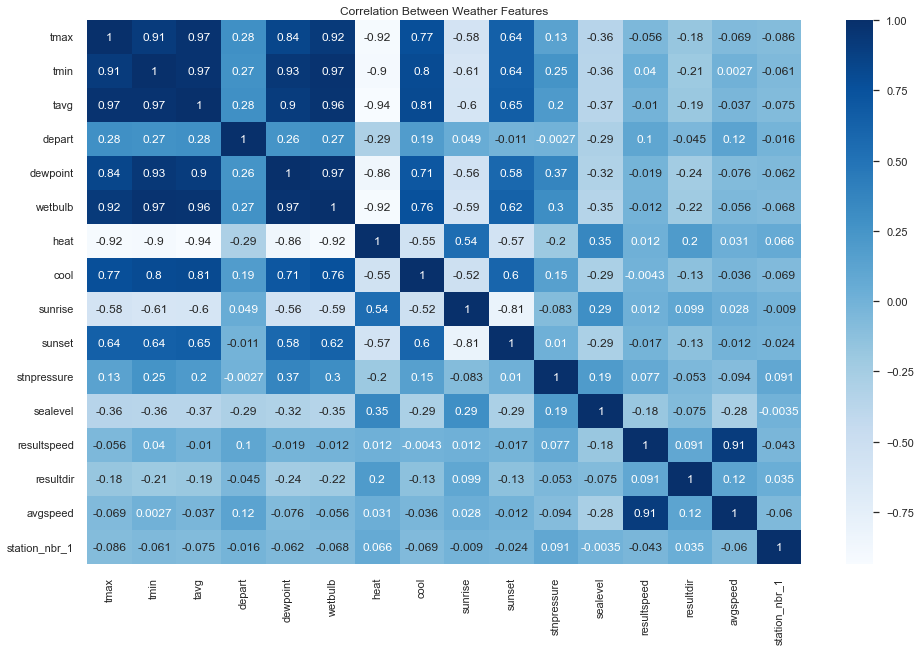

In [247]:
# create correlation heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(cor, annot=True, cmap='Blues')
plt.title("Correlation Between Weather Features")
plt.show()

We can see that none of the features above are highly correlated with the output variable key_sum (in our case we define highly correlated variables as variables with a correlation higher than 0.5), but  
some of them are highly correlated with each other, for example: the features tmax, tmin, tavg, dewpoint, wetbulb, sunset and cool are highly correlated with each other so we'll remove all of them except for the one with the highest correlation with the target variable key_sum which happens to be sunset.
moreover resultspeed and avgspeed also have a high correlation and since avgspeed has a higher correlation with units then we'll remove resultspeed and keep avgspeed instead.
sunrise and heat also have a high correlation so we'll remove sunrise and keep heat since it has a higher correlation with key_sum.
So In conclusion the columns we'll be removing are: tmax, tmin, tavg, dewpoint, wetbulb, units, cool, sunrise and resultspeed.

In [248]:
train_data_scaled = train_data_scaled.drop(['tmin', 'tmax', 'tavg', 'dewpoint', 'wetbulb', 'resultspeed', 'cool', 'sunrise'], 1)
train_data_scaled

,depart,heat,sunset,stnpressure,sealevel,resultdir,avgspeed,station_nbr_1,station_nbr_2,station_nbr_3,...,BCFG_1,MIFG_0,MIFG_1,TS_0,TS_1,VCTS_0,VCTS_1,BLDU_0,BLDU_1,key_sum
4,1.770483,1.017677,-2.282439,0.56056,-0.511183,0.174635,-0.836478,6.611856,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
5,1.770483,1.017677,-2.282439,0.56056,-0.511183,0.174635,-0.836478,6.611856,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
8,1.770483,1.017677,-2.282439,0.56056,-0.511183,0.174635,-0.836478,6.611856,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
15,1.770483,1.017677,-2.282439,0.56056,-0.511183,0.174635,-0.836478,6.611856,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
44,1.770483,1.017677,-2.282439,0.56056,-0.511183,0.174635,-0.836478,6.611856,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583749,-1.189452,0.173616,-2.271037,0.17937,0.527070,0.998773,1.029809,-0.151243,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,12.0
4583750,-1.189452,0.173616,-2.271037,0.17937,0.527070,0.998773,1.029809,-0.151243,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,12.0
4583753,-1.189452,0.173616,-2.271037,0.17937,0.527070,0.998773,1.029809,-0.151243,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,12.0
4583760,-1.189452,0.173616,-2.271037,0.17937,0.527070,0.998773,1.029809,-0.151243,-0.151475,-0.270316,...,-0.086203,0.054398,-0.054398,0.324091,-0.324091,0.157951,-0.157951,0.027169,-0.027169,12.0


In [249]:
test_data_scaled = test_data_scaled.drop(['tmin', 'tmax', 'tavg', 'dewpoint', 'wetbulb', 'resultspeed', 'cool', 'sunrise'], 1)
test_data_scaled

,depart,heat,sunset,stnpressure,sealevel,resultdir,avgspeed,station_nbr_1,station_nbr_2,station_nbr_3,...,BCFG_1,MIFG_0,MIFG_1,TS_0,TS_1,VCTS_0,VCTS_1,BLDU_0,BLDU_1,key_sum
74152,-3.608810,3.180499,-1.125146,0.739793,1.008719,-1.693618,1.374561,6.489044,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
74153,-3.608810,3.180499,-1.125146,0.739793,1.008719,-1.693618,1.374561,6.489044,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
74156,-3.608810,3.180499,-1.125146,0.739793,1.008719,-1.693618,1.374561,6.489044,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
74163,-3.608810,3.180499,-1.125146,0.739793,1.008719,-1.693618,1.374561,6.489044,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
74192,-3.608810,3.180499,-1.125146,0.739793,1.008719,-1.693618,1.374561,6.489044,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617493,-1.680851,0.830914,-3.310098,0.516122,0.020807,-1.383730,0.752015,-0.154106,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,18.0
4617494,-1.680851,0.830914,-3.310098,0.516122,0.020807,-1.383730,0.752015,-0.154106,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,18.0
4617497,-1.680851,0.830914,-3.310098,0.516122,0.020807,-1.383730,0.752015,-0.154106,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,18.0
4617504,-1.680851,0.830914,-3.310098,0.516122,0.020807,-1.383730,0.752015,-0.154106,-0.13026,-0.260257,...,-0.04822,0.04822,-0.04822,0.337646,-0.337646,0.167254,-0.167254,0.024999,-0.024999,18.0


### Bonus Data Preprocessing

In [68]:
weather_sales_filtered.shape

(118696, 23)

In [69]:
weather_sales_filtered.dtypes

station_nbr             int64
date           datetime64[ns]
tmax                  float64
tmin                  float64
tavg                  float64
depart                float64
dewpoint              float64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
snowfall               object
preciptotal            object
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
store_nbr               int64
item_nbr                int64
units                   int64
dtype: object

In [70]:
def change_preciptotal(x):
    if x == "  T":
        return 0.001    
    else:
        return float(x)
    
weather_sales_filtered["preciptotal"] = weather_sales_filtered["preciptotal"].map(change_preciptotal)

In [71]:
def change_snowfall(x):
    if x == "  T":
        return 0.01    
    else:
        return float(x)
    
weather_sales_filtered["snowfall"] = weather_sales_filtered["snowfall"].map(change_snowfall)

In [72]:
weather_sales_filtered['Year'] = pd.DatetimeIndex(weather_sales_filtered['date']).year
weather_sales_filtered['Month'] = pd.DatetimeIndex(weather_sales_filtered['date']).month
weather_sales_filtered['Day'] = pd.DatetimeIndex(weather_sales_filtered['date']).day

In [73]:
# replace codesum field that's entirely space (or empty) with Normal
weather_sales_filtered["codesum"] = weather_sales_filtered["codesum"].replace(r'^\s*$', 'Normal', regex=True)

In [74]:
codesum_columns = set(' '.join(set(weather_sales_filtered["codesum"])).strip().split())

In [75]:
codesum_columns

{'BCFG',
 'BLDU',
 'BLSN',
 'BR',
 'DU',
 'DZ',
 'FG',
 'FG+',
 'FU',
 'FZDZ',
 'FZFG',
 'FZRA',
 'GR',
 'GS',
 'HZ',
 'MIFG',
 'Normal',
 'PL',
 'PRFG',
 'RA',
 'SG',
 'SN',
 'SQ',
 'TS',
 'TSRA',
 'TSSN',
 'UP',
 'VCFG',
 'VCTS'}

In [76]:
codesum_columns = pd.DataFrame(index=weather_sales_filtered.index, columns=codesum_columns)

In [77]:
codesum_columns

,PRFG,FZRA,PL,BCFG,Normal,RA,VCFG,FZDZ,MIFG,GR,...,FG,UP,GS,DU,SG,BR,TSRA,FU,BLSN,VCTS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
for column in codesum_columns.columns:
    for i in weather_sales_filtered.index:
        if column in weather_sales_filtered["codesum"][i]:
            codesum_columns[column][i] = 1

In [79]:
weather_sales_filtered = weather_sales_filtered.drop("codesum", 1)

In [80]:
weather_sales_filtered = weather_sales_filtered.join(codesum_columns.fillna(0))

In [171]:
weather_sales_filtered.iloc[:, 19:] = weather_sales_filtered.iloc[:, 19:].astype('object')
weather_sales_filtered[['units']] = weather_sales_filtered[['units']].astype('float')
weather_sales_filtered[['station_nbr']] = weather_sales_filtered[['station_nbr']].astype('object')
weather_sales_filtered.dtypes

station_nbr     object
tmax           float64
tmin           float64
tavg           float64
depart         float64
                ...   
FU_1            object
BLSN_0          object
BLSN_1          object
VCTS_0          object
VCTS_1          object
Length: 279, dtype: object

In [83]:
weather_sales_filtered = weather_sales_filtered.drop('date', 1)

### One Hot Encoding - Bonuses

In [172]:
# create different datasets for numeric and categorical variables
numeric_features= weather_sales_filtered.select_dtypes(include='number')
categorical_features = weather_sales_filtered.select_dtypes(include='object')

In [173]:
# get categorical variables after dropping observations
categorical_features = weather_sales_filtered[categorical_features.columns]

In [174]:
# one-hot encoding
encoded = pd.get_dummies(categorical_features, drop_first=False)

In [87]:
# drop categorical variables
weather_sales_filtered.drop(categorical_features.columns, axis=1, inplace=True)

In [88]:
# add new encoded variables to the dataframe
weather_sales_filtered = pd.concat([weather_sales_filtered, encoded], axis=1)

In [89]:
weather_sales_filtered

,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,...,BR_0,BR_1,TSRA_0,TSRA_1,FU_0,FU_1,BLSN_0,BLSN_1,VCTS_0,VCTS_1
0,1,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,...,0,1,1,0,1,0,1,0,1,0
1,1,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,...,0,1,1,0,1,0,1,0,1,0
2,1,52.0,31.0,42.0,NaN,36.0,40.0,23.0,0.0,NaN,...,0,1,1,0,1,0,1,0,1,0
3,1,50.0,31.0,41.0,NaN,26.0,35.0,24.0,0.0,NaN,...,1,0,1,0,1,0,1,0,1,0
4,1,50.0,31.0,41.0,NaN,26.0,35.0,24.0,0.0,NaN,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118691,5,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,613.0,...,1,0,1,0,1,0,1,0,1,0
118692,5,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,615.0,...,1,0,1,0,1,0,1,0,1,0
118693,5,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,615.0,...,1,0,1,0,1,0,1,0,1,0
118694,5,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,616.0,...,1,0,1,0,1,0,1,0,1,0


### Normalization - Bonuses

In [90]:
#Normalize Train data
mapper_train = DataFrameMapper([(weather_sales_filtered.columns, StandardScaler())])
scaled_features = mapper_train.fit_transform(weather_sales_filtered.copy(), 4)
data_scaled = pd.DataFrame(scaled_features, index=weather_sales_filtered.index, columns=weather_sales_filtered.columns)
data_scaled

,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,...,BR_0,BR_1,TSRA_0,TSRA_1,FU_0,FU_1,BLSN_0,BLSN_1,VCTS_0,VCTS_1
0,-2.076418,-1.013192,-0.96582,-0.995977,NaN,-0.498969,-0.761967,0.961745,-0.748217,NaN,...,-1.572022,1.572022,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
1,-2.076418,-1.013192,-0.96582,-0.995977,NaN,-0.498969,-0.761967,0.961745,-0.748217,NaN,...,-1.572022,1.572022,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
2,-2.076418,-1.013192,-0.96582,-0.995977,NaN,-0.498969,-0.761967,0.961745,-0.748217,NaN,...,-1.572022,1.572022,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
3,-2.076418,-1.115915,-0.96582,-1.048662,NaN,-1.010269,-1.056836,1.035073,-0.748217,NaN,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
4,-2.076418,-1.115915,-0.96582,-1.048662,NaN,-1.010269,-1.056836,1.035073,-0.748217,NaN,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118691,-1.269704,NaN,NaN,NaN,NaN,0.472501,NaN,NaN,NaN,0.173557,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
118692,-1.269704,NaN,NaN,NaN,NaN,-0.396709,NaN,NaN,NaN,0.196762,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
118693,-1.269704,NaN,NaN,NaN,NaN,-0.396709,NaN,NaN,NaN,0.196762,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
118694,-1.269704,NaN,NaN,NaN,NaN,-0.447839,NaN,NaN,NaN,0.208364,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868


In [91]:
# use KNN to impute missing values
imputer = KNNImputer(n_neighbors=5, weights="distance")
imputed_data = imputer.fit_transform(data_scaled)

# replace values in the dataset with new imputed values
data_scaled[data_scaled.columns] = imputed_data

In [92]:
# missing values by variable
data_scaled.isna().sum().sort_values(ascending = False).head(15)

station_nbr    0
Month_7        0
Day_1          0
Month_12       0
Month_11       0
Month_10       0
Month_9        0
Month_8        0
Month_6        0
Year_2012      0
Month_5        0
Month_4        0
Month_3        0
Month_2        0
Month_1        0
dtype: int64

In [99]:
data_scaled.iloc[:, 1:19]

,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,units
0,-1.013192,-0.965820,-0.995977,0.788935,-0.498969,-0.761967,0.961745,-0.748217,0.034709,-0.992990,-0.058225,-0.096786,0.573677,-0.494895,-0.659473,0.170066,-0.867404,-0.193410
1,-1.013192,-0.965820,-0.995977,0.778001,-0.498969,-0.761967,0.961745,-0.748217,0.021838,-0.979671,-0.058225,-0.096786,0.573677,-0.494895,-0.659473,0.170066,-0.867404,-0.749412
2,-1.013192,-0.965820,-0.995977,1.226554,-0.498969,-0.761967,0.961745,-0.748217,1.011780,-1.851541,0.282302,-0.096786,0.573677,-0.494895,-0.659473,0.170066,-0.867404,-0.770005
3,-1.115915,-0.965820,-1.048662,0.475517,-1.010269,-1.056836,1.035073,-0.748217,1.469444,-1.324955,-0.051467,-0.230577,0.386994,-2.073391,0.806434,0.582140,0.578528,0.444963
4,-1.115915,-0.965820,-1.048662,-0.273696,-1.010269,-1.056836,1.035073,-0.748217,1.444902,-1.308949,-0.051457,-0.230577,0.386994,-2.073391,0.806434,0.582140,0.578528,-0.687634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118691,-0.234262,-0.084721,-0.153255,-0.358808,0.472501,-0.065407,-0.197925,-0.724890,0.173557,-2.155151,-0.058225,-0.028466,-0.053389,-0.757978,0.428135,0.479121,0.778511,-0.502300
118692,-0.504977,-0.264009,-0.388028,-0.476763,-0.396709,-0.632910,0.115600,-0.748217,0.196762,-2.178199,-0.058225,-0.264024,0.449993,-0.337046,0.451779,1.200252,0.389261,-0.461115
118693,-0.247046,-0.072362,-0.153575,-0.362353,-0.396709,-0.677949,-0.197356,-0.724671,0.196762,-2.178199,-0.058225,-0.026257,-0.663316,-0.337046,0.451779,1.200252,0.674451,-0.667041
118694,-0.402033,-0.279705,-0.344241,-0.586923,-0.447839,-0.289434,0.054657,-0.748217,0.208364,-2.189723,-0.058225,-0.264024,0.479217,-0.021347,1.042870,-1.375213,-0.515504,-0.419929


In [100]:
cor = data_scaled.iloc[:, 1:19].corr()
cor

,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,units
tmax,1.000000,0.913589,0.976298,0.362265,0.848917,0.927440,-0.926873,0.759412,-0.578653,0.685013,-0.191172,0.027745,0.142538,-0.363047,-0.057057,-0.159948,-0.067962,-0.018645
tmin,0.913589,1.000000,0.976086,0.337738,0.936114,0.970507,-0.906420,0.794879,-0.604856,0.676443,-0.159129,0.107120,0.260179,-0.358192,0.027843,-0.193473,-0.011158,-0.031393
tavg,0.976298,0.976086,1.000000,0.356957,0.911179,0.968962,-0.938996,0.796110,-0.602825,0.694853,-0.178615,0.068967,0.207076,-0.367286,-0.015676,-0.180125,-0.041612,-0.026587
depart,0.362265,0.337738,0.356957,1.000000,0.322180,0.344073,-0.365583,0.230683,0.025261,0.000694,-0.062263,-0.020906,0.040974,-0.350751,0.092354,-0.044227,0.112086,0.012708
dewpoint,0.848917,0.936114,0.911179,0.322180,1.000000,0.970599,-0.857401,0.722217,-0.551313,0.612802,-0.133330,0.153966,0.365260,-0.311876,-0.038865,-0.225864,-0.095592,-0.043693
wetbulb,0.927440,0.970507,0.968962,0.344073,0.970599,1.000000,-0.915929,0.760706,-0.594255,0.672901,-0.167824,0.113596,0.306144,-0.343522,-0.025068,-0.208144,-0.070267,-0.037604
heat,-0.926873,-0.906420,-0.938996,-0.365583,-0.857401,-0.915929,1.000000,-0.539415,0.558507,-0.623825,0.206084,-0.073597,-0.185195,0.356613,0.023628,0.176090,0.037427,0.035244
cool,0.759412,0.794879,0.796110,0.230683,0.722217,0.760706,-0.539415,1.000000,-0.493187,0.603570,-0.074693,0.039356,0.181129,-0.271755,0.003195,-0.131165,-0.036026,-0.003079
sunrise,-0.578653,-0.604856,-0.602825,0.025261,-0.551313,-0.594255,0.558507,-0.493187,1.000000,-0.786903,0.085094,-0.094401,-0.030336,0.291749,0.001029,0.080769,0.004410,0.045945
sunset,0.685013,0.676443,0.694853,0.000694,0.612802,0.672901,-0.623825,0.603570,-0.786903,1.000000,-0.151078,0.075236,0.048574,-0.281983,-0.003367,-0.126214,0.010605,0.005052


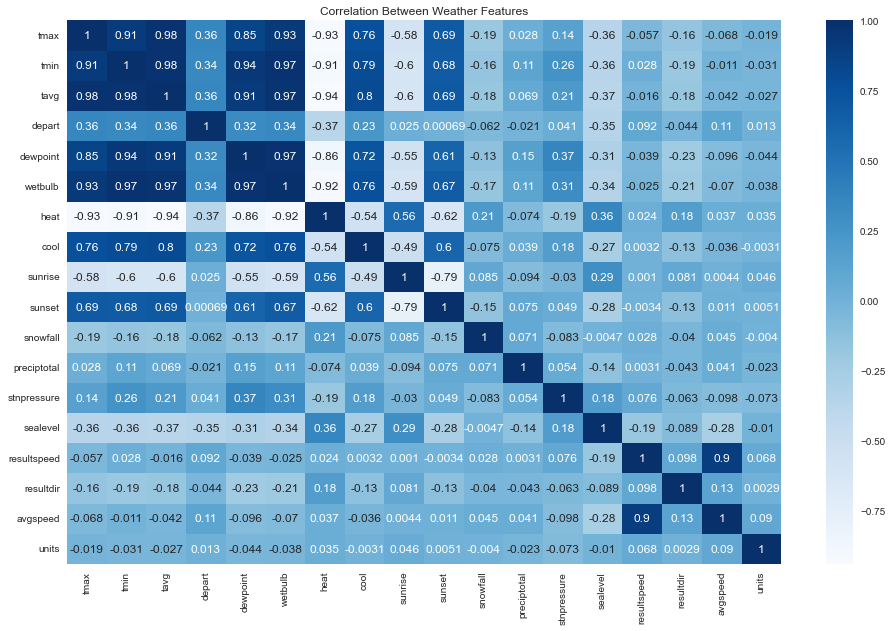

In [101]:
# create correlation heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(cor, annot=True, cmap='Blues')
plt.title("Correlation Between Weather Features")
plt.show()

As we discussed before we remove the same features except that this time we remove heat instead of sunrise becuase it has a higher correlation with units

In [102]:
data_scaled = data_scaled.drop(['tmin', 'tmax', 'tavg', 'dewpoint', 'wetbulb', 'resultspeed', 'cool', 'heat'], 1)
data_scaled

,station_nbr,depart,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultdir,avgspeed,...,BR_0,BR_1,TSRA_0,TSRA_1,FU_0,FU_1,BLSN_0,BLSN_1,VCTS_0,VCTS_1
0,-2.076418,0.788935,0.034709,-0.992990,-0.058225,-0.096786,0.573677,-0.494895,0.170066,-0.867404,...,-1.572022,1.572022,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
1,-2.076418,0.778001,0.021838,-0.979671,-0.058225,-0.096786,0.573677,-0.494895,0.170066,-0.867404,...,-1.572022,1.572022,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
2,-2.076418,1.226554,1.011780,-1.851541,0.282302,-0.096786,0.573677,-0.494895,0.170066,-0.867404,...,-1.572022,1.572022,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
3,-2.076418,0.475517,1.469444,-1.324955,-0.051467,-0.230577,0.386994,-2.073391,0.582140,0.578528,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
4,-2.076418,-0.273696,1.444902,-1.308949,-0.051457,-0.230577,0.386994,-2.073391,0.582140,0.578528,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118691,-1.269704,-0.358808,0.173557,-2.155151,-0.058225,-0.028466,-0.053389,-0.757978,0.479121,0.778511,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
118692,-1.269704,-0.476763,0.196762,-2.178199,-0.058225,-0.264024,0.449993,-0.337046,1.200252,0.389261,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
118693,-1.269704,-0.362353,0.196762,-2.178199,-0.058225,-0.026257,-0.663316,-0.337046,1.200252,0.674451,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868
118694,-1.269704,-0.586923,0.208364,-2.189723,-0.058225,-0.264024,0.479217,-0.021347,-1.375213,-0.515504,...,0.636124,-0.636124,0.244705,-0.244705,0.051254,-0.051254,0.04983,-0.04983,0.159868,-0.159868


# 4 Unit Sales Prediction <a class="anchor" id="section4"></a>

In [250]:
# split dataset to features and label
X_train = train_data_scaled.drop('key_sum', axis=1)
y_train = train_data_scaled['key_sum']
X_test = test_data_scaled.drop('key_sum', axis=1)
y_test = test_data_scaled['key_sum']

## 4.1 AdaBoost Regressor

In [268]:
# define model
ab = AdaBoostRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate':[0.01, 0.1, 1.0]
}

# define grid search
grid_search = GridSearchCV(estimator=ab, param_grid=parameters_grid, cv=10)

In [269]:
# fit estimator
grid_search.fit(X_train, y_train)

# get best estimator
best = grid_search.best_estimator_

In [270]:
# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,learning_rate,n_estimators
Selected Value,0.1,100.0


In [271]:
# predict on train data 
y_pred = best.predict(X_train)

In [272]:
# calculate MSE, MAE, RMSE and R Squared for train data
MSE = round(mean_squared_error(y_train, y_pred), 3)
MAE = round(mean_absolute_error(y_train,y_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_train,y_pred)), 3)
R2 = round(r2_score(y_train,y_pred), 3)

df = pd.DataFrame([MSE, MAE, RMSE, R2]).T
df = df.rename(index={0: 'AdaBoost Regressor'}, columns={0: 'MSE', 1:'MAE', 2:'RMSE', 3:"R2"})
df

,MSE,MAE,RMSE,R2
AdaBoost Regressor,2685.385,39.193,51.821,0.48


In [273]:
# predict on test data 
y_pred = best.predict(X_test)

In [274]:
# calculate MSE, MAE, RMSE and R Squared for test data
MSE = round(mean_squared_error(y_test, y_pred), 3)
MAE = round(mean_absolute_error(y_test,y_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_test,y_pred)), 3)
R2 = round(r2_score(y_test,y_pred), 3)

df = pd.DataFrame([MSE, MAE, RMSE, R2]).T
df = df.rename(index={0: 'AdaBoost Regressor'}, columns={0: 'MSE', 1:'MAE', 2:'RMSE', 3:"R2"})
df

,MSE,MAE,RMSE,R2
AdaBoost Regressor,2189.333,37.236,46.79,0.121


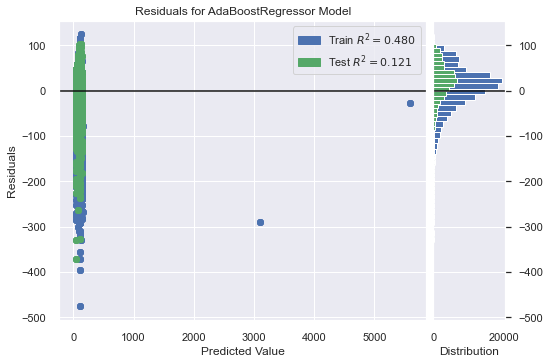

In [276]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(AdaBoostRegressor(random_state=RSEED, learning_rate=0.1, n_estimators=100), X_train, y_train, X_test, y_test)

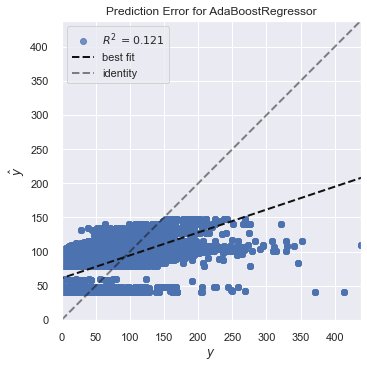

<AxesSubplot:title={'center':'Prediction Error for AdaBoostRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [278]:
visualizer = PredictionError(AdaBoostRegressor(random_state=RSEED, learning_rate=0.1, n_estimators=100))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

## 4.2 Regression Tree

In [252]:
# define model
dt = DecisionTreeRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [2, 8]
}


# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)

In [253]:
# fit estimator
grid_search.fit(X_train, y_train)

# get best estimator
best = grid_search.best_estimator_

In [254]:
# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,max_depth,min_samples_leaf,min_samples_split
Selected Value,6,8,2


In [257]:
# predict on train data 
y_pred = best.predict(X_train)

In [258]:
# calculate MSE, MAE, RMSE and R Squared for train data
MSE = round(mean_squared_error(y_train, y_pred), 3)
MAE = round(mean_absolute_error(y_train,y_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_train,y_pred)), 3)
R2 = round(r2_score(y_train,y_pred), 3)

df = pd.DataFrame([MSE, MAE, RMSE, R2]).T
df = df.rename(index={0: 'Regression Tree'}, columns={0: 'MSE', 1:'MAE', 2:'RMSE', 3:"R2"})
df

,MSE,MAE,RMSE,R2
Regression Tree,3104.523,30.294,55.718,0.399


In [259]:
# predict
y_pred = best.predict(X_test)

In [260]:
# calculate MSE, MAE, RMSE and R Squared for test data
MSE = round(mean_squared_error(y_test, y_pred), 3)
MAE = round(mean_absolute_error(y_test,y_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_test,y_pred)), 3)
R2 = round(r2_score(y_test,y_pred), 3)

df = pd.DataFrame([MSE, MAE, RMSE, R2]).T
df = df.rename(index={0: 'Regression Tree'}, columns={0: 'MSE', 1:'MAE', 2:'RMSE', 3:"R2"})
df

,MSE,MAE,RMSE,R2
Regression Tree,1743.922,31.798,41.76,0.3


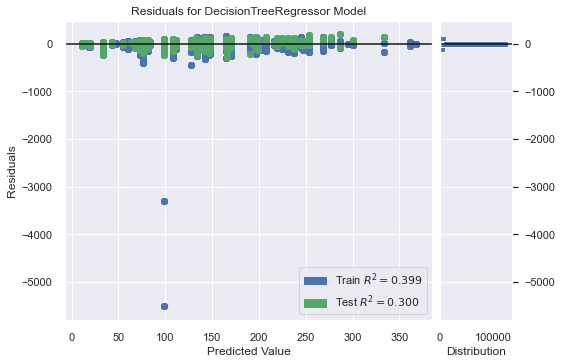

In [261]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 8, min_samples_split = 2), X_train, y_train, X_test, y_test)

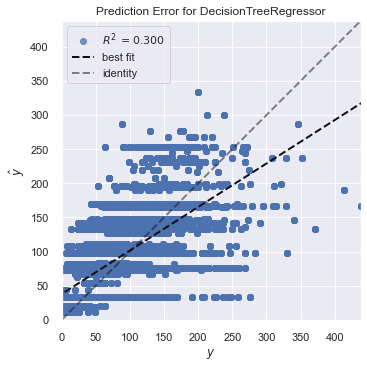

<AxesSubplot:title={'center':'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [262]:
visualizer = PredictionError(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 8, min_samples_split = 2))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

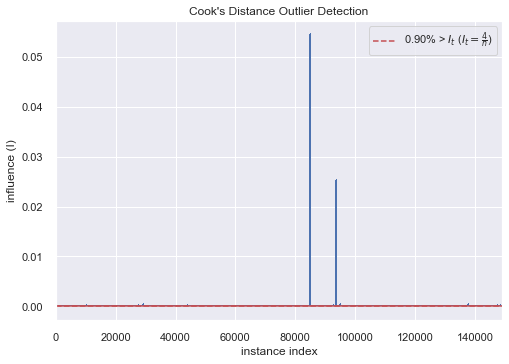

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [263]:
from yellowbrick.regressor import CooksDistance

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X_train, y_train)
visualizer.show()

In the graph above we can clearly see that there is some outliers in the training data

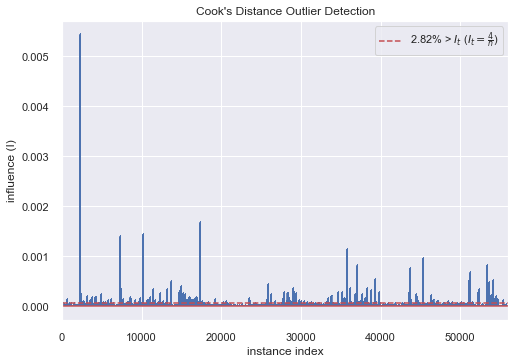

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [264]:
visualizer_test = CooksDistance()
visualizer_test.fit(X_test, y_test)
visualizer_test.show()

In The graph above we can see that there are a good amount of outliers in the test data which could affect the performance of the models we're going to build since least squares estimates for regression models are highly sensitive to outliers.

In [265]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

In [266]:
imp = imp.nlargest(10, 'Importance')
imp

,Importance
stnpressure,0.453340
station_nbr_17,0.062310
store_nbr_25,0.054899
store_nbr_18,0.052180
store_nbr_34,0.048011
store_nbr_17,0.044443
store_nbr_15,0.043983
store_nbr_38,0.040925
store_nbr_31,0.033645
IsWeekend_True,0.027891


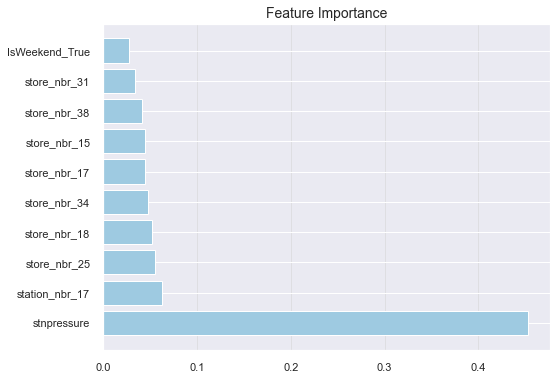

In [267]:
# plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(0, len(imp)), imp['Importance'], color='#9ecae1')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=14)
plt.show()

Surprisingly enough out of the many weather features only 1 is present(Not including station_nbr) in the top 10 most important features that will have a larger effect on the model that is being used to predict key_sum while stnpressure being the most important feature for the model

## 4.3 Random Forest Regressor

In [279]:
# define model
rf = RandomForestRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 8],
    'n_estimators': [20, 50]
}

# define grid search
grid_search = GridSearchCV(estimator=rf, param_grid=parameters_grid, cv=10)

In [280]:
# fit estimator
grid_search.fit(X_train, y_train)

# get best estimator
best = grid_search.best_estimator_

In [281]:
# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,max_depth,min_samples_leaf,min_samples_split,n_estimators
Selected Value,3,2,2,20


In [282]:
# predict on train data 
y_pred = best.predict(X_train)

In [283]:
# calculate MSE, MAE, RMSE and R Squared for train data
MSE = round(mean_squared_error(y_train, y_pred), 3)
MAE = round(mean_absolute_error(y_train,y_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_train,y_pred)), 3)
R2 = round(r2_score(y_train,y_pred), 3)

df = pd.DataFrame([MSE, MAE, RMSE, R2]).T
df = df.rename(index={0: 'Random Forest Regressor'}, columns={0: 'MSE', 1:'MAE', 2:'RMSE', 3:"R2"})
df

,MSE,MAE,RMSE,R2
Random Forest Regressor,3762.657,36.378,61.341,0.271


In [284]:
# predict
y_pred = best.predict(X_test)

In [285]:
# calculate MSE, MAE, RMSE and R Squared for test data
MSE = round(mean_squared_error(y_test, y_pred), 3)
MAE = round(mean_absolute_error(y_test,y_pred), 3)
RMSE = round(np.sqrt(mean_squared_error(y_test,y_pred)), 3)
R2 = round(r2_score(y_test,y_pred), 3)

df = pd.DataFrame([MSE, MAE, RMSE, R2]).T
df = df.rename(index={0: 'Random Forest Regressor'}, columns={0: 'MSE', 1:'MAE', 2:'RMSE', 3:"R2"})
df

,MSE,MAE,RMSE,R2
Random Forest Regressor,1852.558,33.695,43.041,0.256


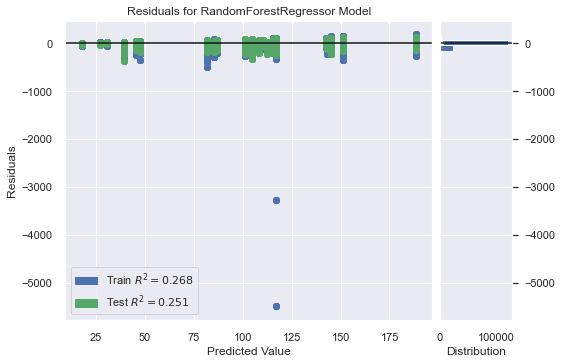

In [286]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(RandomForestRegressor(max_depth = 3, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 20), X_train, y_train, X_test, y_test)

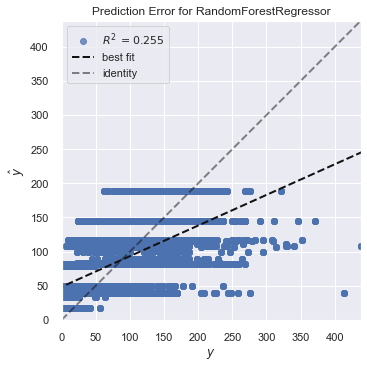

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [287]:
visualizer = PredictionError(RandomForestRegressor(max_depth = 3, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 20))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

In [288]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

In [289]:
imp = imp.nlargest(10, 'Importance')
imp

,Importance
stnpressure,0.690477
station_nbr_17,0.089777
store_nbr_25,0.080126
store_nbr_17,0.051325
store_nbr_18,0.040877
station_nbr_20,0.040062
store_nbr_34,0.007355
depart,0.000000
Day_30,0.000000
Day_31,0.000000


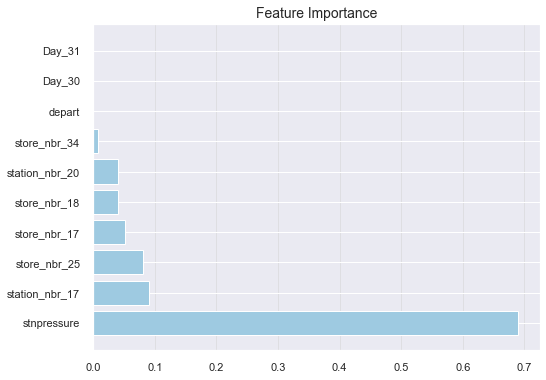

In [290]:
# plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(0, len(imp)), imp['Importance'], color='#9ecae1')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=14)
plt.show()

Simliarly to the previous model stnpressure is also in the top 10 list of important features although in this case there is another weather feature which is depart but being towards to the lower end.

### Comparing The Results

|Model | MSE | MAE | R2 |
|:- | :- | :- | :- |
|AdaBoostRegressor | 2189.333 | 37.236 | 0.121 |
|DecisionTreeRegressor | 1743.922 | 31.798 | 0.3 |
|RandomForestRegressor | 1852.558 | 33.695 | 0.256 |

Even though the results are close but we clearly have a Winner! DecisionTreeRegressor outperformed the other models by getting the lowest and best values for all metrics including R2 which means it is also the most reliable(Even though R2 is still low) followed by RandomForestRegressor and AdaBoostRegressor

# 5 Rainy Day Prediction <a class="anchor" id="section5"></a>

### 5.1 Random Forest Classifier

In [124]:
train_data = rainy_day[pd.DatetimeIndex(rainy_day['date']).year <= 2013]
test_data = rainy_day[pd.DatetimeIndex(rainy_day['date']).year == 2014]

In [125]:
train_data = train_data.drop('date', 1)
test_data = test_data.drop('date', 1)

In [126]:
# split dataset to features and label
X_train = train_data.drop('Rainy_Day', axis=1)
y_train = train_data['Rainy_Day']
y_train = y_train.astype('int')
X_test = train_data.drop('Rainy_Day', axis=1)
y_test = train_data['Rainy_Day']
y_test = y_test.astype('int')

In [152]:
# define function to calculate metrics
def get_metrics(y_test, y_pred):
    
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # get confusion matrix
    mat = metrics.confusion_matrix(y_test, y_pred)
    true_neg, false_pos, false_neg, true_pos = mat.ravel()
    
    # calculate sensitivity and specificity
    sensitivity = round(true_pos / np.sum(actual_pos), 3)
    specificity = round(true_neg / np.sum(actual_neg), 3)
    
    return sensitivity, specificity

In [153]:
# define model
rf = RandomForestClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 4, 6],
    'n_estimators': [20, 50, 80, 100]
}

# define grid search
grid_search = GridSearchCV(estimator=rf, param_grid=parameters_grid, cv=10)

In [154]:
# fit estimator
grid_search.fit(X_train, y_train)

# get best estimator
best = grid_search.best_estimator_

In [155]:
# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,max_depth,min_samples_leaf,min_samples_split,n_estimators
Selected Value,6,4,2,20


In [156]:
# predict
y_pred = best.predict(X_test)

In [157]:
# calculate metrics
acc = round(accuracy_score(y_test, y_pred), 3)
sensitivity, specificity = get_metrics(y_test, y_pred)

# display metrics
rf_df = pd.DataFrame([acc, sensitivity, specificity]).T
rf_df = rf_df.rename(index={0: 'Random Forest Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity'})
rf_df

,Accuracy,Sensitivity,Specificity
Random Forest Classifier,0.695,0.548,0.833


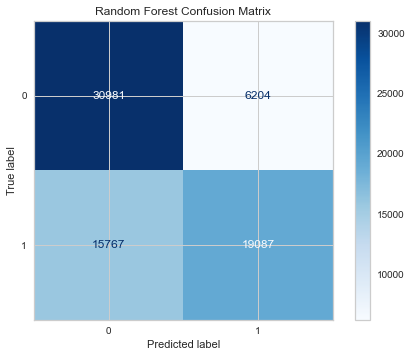

In [158]:
# plot confusion metrics
plot_confusion_matrix(best, X_test, y_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

### 5.2 Gradient Boosting Classifer

In [140]:
# define model
gb = GradientBoostingClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'learning_rate': [0.5, 1, 1.5, 2],
    'n_estimators': [50, 100, 200]

}

# define grid search
grid_search = GridSearchCV(estimator=gb, param_grid=parameters_grid, cv=10)

In [141]:
# fit estimator
grid_search.fit(X_train, y_train)

# get best estimator
best = grid_search.best_estimator_

In [142]:
# print best parameters
pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T

,learning_rate,n_estimators
Selected Value,2,50


In [145]:
# predict
y_pred = best.predict(X_test)

In [146]:
# calculate metrics
acc = round(accuracy_score(y_test, y_pred), 3)
sensitivity, specificity = get_metrics(y_test, y_pred)

# display metrics
gb_df = pd.DataFrame([acc, sensitivity, specificity]).T
gb_df = gb_df.rename(index={0: 'Gradient Boosting Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity'})
gb_df

,Accuracy,Sensitivity,Specificity
Gradient Boosting Classifier,0.622,0.478,0.758


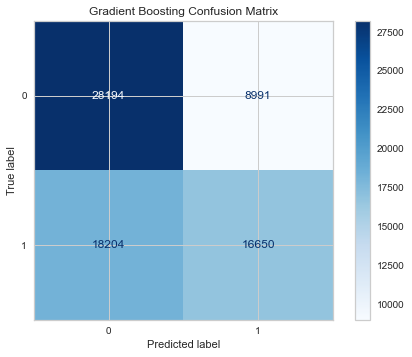

In [147]:
# plot confusion metrics
plot_confusion_matrix(best, X_test, y_test, cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

In [148]:
# get feature importance
imp = pd.DataFrame(grid_search.best_estimator_.fit(X_train, y_train).feature_importances_, 
                   index=X_train.columns, columns=['Importance']).sort_values('Importance')

In [150]:
imp = imp.nlargest(10, 'Importance')
imp

,Importance
Month_9,0.408786
Month_5,0.323752
Day_22,0.151385
Day_19,0.063117
Year_2013,0.014282
Day_10,0.006198
Day_20,0.005189
Day_25,0.004919
Day_3,0.004730
Month_8,0.002236


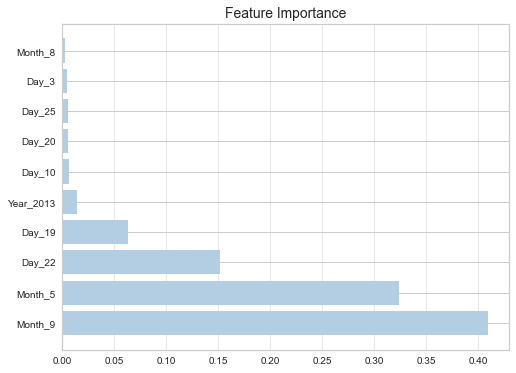

In [151]:
# plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(0, len(imp)), imp['Importance'], color='#b3cde3')
plt.grid(axis='x', alpha=0.5, color='lightgrey')
plt.yticks(range(0, len(imp)), imp.index)
plt.title('Feature Importance', fontsize=14)
plt.show()

### Comparing The Results

|Model | Accuracy | Sensitivity | Specificity |
|:- | :- | :- | :- |
|Random Forest Classifier | 0.695 | 0.548 | 0.833 |
|Gradient Boosting Classifier | 0.622 | 0.478 | 0.758 |

### While the accuracy isn't that good for both models still The Random Forest Classifer outperformed the Gradient Boosting Classifier with a difference of roughly 8% in terms of accuracy, 7% in terms of Sensitivity and 9% in Specificity.
### A possible explanation for why the Random Forest Classifier outperformed the Gradient Boosting Classifier is that the data is noisy which means the boosted trees may have overfitted and started modeling the noise.
### Looking at the Sensitivity and Specificity Metrics we can see that we got a high Specificity which means there are few false positive results, on the other hand we got low Sensitivity which means there are many false negative results

# 6 Elevation Estimation <a class="anchor" id="section6"></a>

To estimate the elevation we're going to use the formula below:<br>
H = 44330 * [1 - (P/p0)^(1/5.255)]<br>
H = Estimated Elevation<br>
P = stnpressure in the dataframe<br>
p0 = sealevel in the dataframe

In [151]:
elevation_data = data_scaled.copy()
elevation_data['elevation'] = elevation_data['stnpressure'] / elevation_data['sealevel']
x = 1 / 5.255
tmp1 = elevation_data[elevation_data['elevation'] > 0]
tmp1['elevation'] = 44330 * ( 1 - pow(tmp1['elevation'], x))
tmp2 = elevation_data[elevation_data['elevation'] < 0]
tmp2['elevation'] = 44330 * ( 1 - -1 * pow(np.abs(tmp2['elevation']), x))
elevation_data = tmp1.append(tmp2)
elevation_data['elevation']

8         -20486.674606
9         -20486.674606
16         -2041.427622
17         -2041.427622
18         -2041.427622
              ...      
118688    103706.136789
118689    124277.232989
118690     85162.464719
118692     91166.349251
118694    124465.537442
Name: elevation, Length: 118696, dtype: float64

# 7 Clustering <a class="anchor" id="section7"></a>

In [206]:
# K-Means
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

To select the best value of K for our dataset, we first define a function to create an elbow plot.

In [159]:
def elbow_met(df):

    # k means determine k
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within groups sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

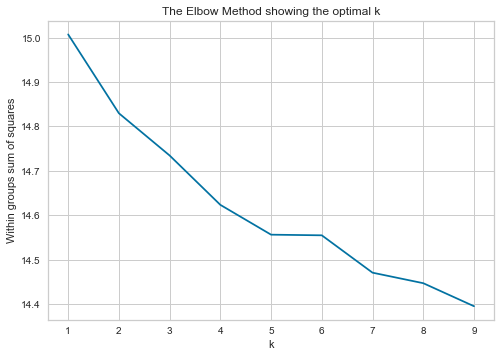

In [160]:
elbow_met(data_scaled)

We select K = 6 to fit the model

In [220]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_scaled)

In [221]:
centroids = kmeans.cluster_centers_
print(centroids)

[[-3.29408521e-02 -7.33773419e-02  2.02094749e-01 ... -4.98303739e-02
   1.59867837e-01 -1.59867837e-01]
 [ 1.91946963e-01  5.32570079e-02  1.91561795e-01 ... -2.59373671e-02
   1.59867837e-01 -1.59867837e-01]
 [ 1.28372865e-03 -7.35630677e-02  2.62385495e-01 ...  1.11619873e-02
   1.59867837e-01 -1.59867837e-01]
 [ 1.12167366e-01  7.93023971e-02 -5.49668199e-01 ... -1.62473478e-02
   1.59867837e-01 -1.59867837e-01]
 [-1.03453857e-01  1.54233817e-01  6.10944976e-01 ...  5.36780087e-01
   9.22581258e-02 -9.22581258e-02]
 [-2.51079880e-03  2.37057389e-02 -5.04245740e-01 ... -4.98303739e-02
  -1.82335924e+00  1.82335924e+00]]


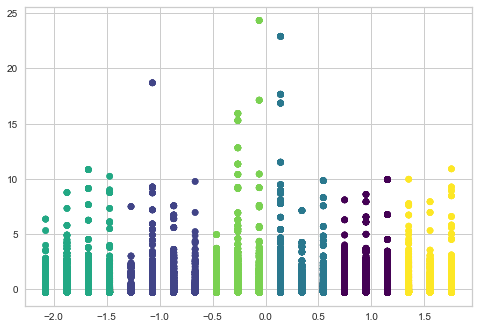

In [222]:
X = data_scaled[['station_nbr']]
Y = data_scaled[['preciptotal']]
labels = kmeans.fit(X).predict(X)
plt.scatter(X, Y, c=labels, s=40, cmap='viridis');

Interestingly enough the clusters are similar to each other which makes it actually difficult for the algorithm to cluster the data and get a meaning out of it so it seems, the 2 clusters in the middle look actually the most similar to each other followed by the 2 clusters on the far right and the 2 clusters on the far left.